<a href="https://colab.research.google.com/github/rodrigodemend/Previsao_Covid/blob/main/Notebooks/Previs%C3%A3o_de_Series_Temporais_usando_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Projeto de Previsão de Series Temporais usando Prophet - Bootcamp Data Science Alura
Autor: Rodrigo de Mendonça 

<a href="https://www.linkedin.com/in/rodrigomendonça/" alt="linkedin" target="_blank">
<img src="https://img.shields.io/badge/LinkedIn-%230077B5.svg?&style=flat-square&logo=linkedin&logoColor=white">
</a>

E-mail: rodrigodemend@gmail.com


Este projeto consiste na previsão do número de mortes por Covid-19 em Santa Catarina e será desenvolvido utilizando o framework Prophet. Uma biblioteca dedicada a previsão de series temporais.

#Importando todas as bibliotecas

O primeiro passo em qualquer projeto de machine learning é a importação das bibliotecas que serão utilizadas no projeto.

Como nosso objetivo é prever as mortes por Covid-19 no estado de Santa Catarina, iremos utilizar principalmente o prophet criado pelo facebook para criação de previsões de series temporais. 

Além do prophet iremos utilizar bibliotecas comumente usadas em projeto de machine learning como pandas, numpy, matplotlib e seaborn.  

In [ ]:
# Instalando o prophet uma vez que o google colab não vem com ele instalado
!pip install prophet

In [ ]:
# Importando todas as bibliotecas necessárias 

import pandas as pd
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from prophet.plot import add_changepoints_to_plot
from sklearn.model_selection import ParameterGrid
from pandas.plotting import autocorrelation_plot
import seaborn as sns
from matplotlib import transforms, pyplot as plt
%matplotlib inline
import numpy as np

# Fazendo um filtro para que os avisos não apareçam e não polua o notebook

import warnings
warnings.filterwarnings('ignore')

#Importando os dados limpos

Nesta seção estamos fazendo a importação dos dados que serão utilizados para a criação do modelo.

O conjunto de dados diz a respeito do número de novas mortes por Covid-19 de 25 de Fevereiro de 2020 até 20 de Dezembro de 2021. Nossa previsão será sobre o estado de Santa Catarina, mas afim de facilitar futuros trabalhos sobre os outros estados, resolvi fazer a importação de todos os estados do Brasil.


Os dados foram obtidos através do [Brasil.IO](https://brasil.io/dataset/covid19/caso_full/) onde estão sendo disponibilizados boletins informativos sobre os casos do coronavírus.

Afim de organizar melhor o projeto, os dados que utilizaremos foram importados e limpos neste [Notebook](https://github.com/rodrigodemend/Previsao_Covid/blob/main/Notebooks/Importação_e_Limpeza_dos_dados_de_Covid_19.ipynb) que se encontra nesse mesmo repositório. Agora iremos importar os dados já limpos e pronto para análise.

In [ ]:
# Importando os dados já preparados para análise
data_new_deaths = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Cleaned/data_new_deaths.csv', encoding='utf-8')
data_new_deaths['date'] = pd.to_datetime(data_new_deaths['date']) # Passando para tipo Data
data_new_deaths.tail()

,date,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,MG,MS,MT,PA,PB,PE,PI,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
660,2021-12-16,0.0,2.0,3.0,0.0,4.0,4.0,3.0,2.0,0.0,2.0,24.0,0.0,2.0,12.0,0.0,6.0,2.0,4.0,5.0,7.0,4.0,2.0,17.0,9.0,0.0,0.0,0.0
661,2021-12-17,0.0,2.0,0.0,0.0,7.0,0.0,7.0,13.0,0.0,3.0,19.0,0.0,5.0,6.0,0.0,10.0,6.0,1.0,0.0,2.0,2.0,0.0,12.0,10.0,0.0,259.0,0.0
662,2021-12-18,0.0,1.0,0.0,0.0,2.0,7.0,0.0,1.0,0.0,2.0,17.0,0.0,0.0,1.0,7.0,5.0,0.0,2.0,30.0,0.0,2.0,0.0,5.0,4.0,1.0,51.0,0.0
663,2021-12-19,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,2.0,15.0,0.0,0.0,1.0,0.0,4.0,4.0,0.0,7.0,3.0,1.0,0.0,4.0,5.0,0.0,0.0,0.0
664,2021-12-20,0.0,2.0,0.0,1.0,6.0,10.0,3.0,11.0,0.0,3.0,1.0,0.0,3.0,7.0,2.0,4.0,4.0,2.0,2.0,0.0,7.0,0.0,2.0,2.0,1.0,0.0,0.0


#Funções utilizadas no notebook

Nesta seção está sendo apresentado todas as funções que foram criadas nesse notebook para ajudar no reaproveitamento de código e organização do mesmo.

In [ ]:
def prophet_model(df, parameters=None, sazon=False, sazon_param=None, i=0, country_holidays=False):
  """
  Função criada para facilitar a criação do modelo com novos parâmetros e teste com cross validation
  """
  if parameters != None:
    modelo = Prophet(**parameters)
  else:
    modelo = Prophet()
  if sazon:
    modelo.add_seasonality(name='sazon_'+str(i), **sazon_param)
  if country_holidays:
    modelo.add_country_holidays(country_name='BR')
  modelo.fit(df)
  df_cv = cross_validation(modelo, initial='400 days', period='30 days', horizon='30 days')
  return performance_metrics(df_cv), modelo

In [ ]:
def prophet_model_grid(df, grid):
  """
  Função criada para facilitar a criação do modelo com um grid de parâmetros e teste com cross validation, salvando em 2 dataframes para o MAE e o RMSE.
  """
  MAE = pd.DataFrame()
  RMSE = pd.DataFrame()
  for i in range(len(grid)):
    print('======================= '+str(i)+' ====================================')
    df_p, _ = prophet_model(df, parameters=grid[i])
    MAE[str(i)] = df_p['mae']
    RMSE[str(i)] = df_p['rmse']
  return MAE, RMSE

In [ ]:
def prophet_model_grid_sazon(df, param, grid):
  """
  Função criada para facilitar a criação do modelo com um grid de parâmetros e teste com cross validation, salvando em 2 dataframes para o MAE e o RMSE.
  Está função serve para parâmetrização da sazonalidade com um grid de parâmetros.
  """
  MAE = pd.DataFrame()
  RMSE = pd.DataFrame()
  for i in range(len(grid)):
    print('======================= '+str(i)+' ====================================')
    df_p, _ = prophet_model(df, parameters=param, sazon=True, sazon_param=grid[i], i=i)
    MAE[str(i)] = df_p['mae']
    RMSE[str(i)] = df_p['rmse']
  return MAE, RMSE

In [ ]:
def prophet_model_country_holidays(df, parameters, country_holidays, holidays_prior_scale_list):
  """
  Está função ajuda na otimização do holidays_prior_scale com os feriados nacionais inclusos
  """
  MAE = pd.DataFrame()
  RMSE = pd.DataFrame()
  for i in range(len(holidays_prior_scale_list)):
    parameters['holidays_prior_scale'] = holidays_prior_scale_list[i]
    print('======================= '+str(i)+' ====================================')
    df_p, _ = prophet_model(df, parameters=parameters, country_holidays=country_holidays)
    MAE[str(i)] = df_p['mae']
    RMSE[str(i)] = df_p['rmse']
  return MAE, RMSE

In [ ]:
def prophet_model_holidays(df, parameters, holidays, prior_scale, initial_i=0, initial_j=0, jump=None):
  MAE = pd.DataFrame({'holiday': [], 'prior_scale': [], 'MAE_Mean': []})
  RMSE = pd.DataFrame({'holiday': [], 'prior_scale': [], 'RMSE_Mean': []})
  nome_feriados = list(holidays['holiday'].unique())
  for i in range(initial_i, len(nome_feriados)):
    df_holidays = holidays[holidays['holiday'] == nome_feriados[i]].copy()
    for j in range(initial_j, len(prior_scale)):
      check_jump = jump_function(jump, nome_feriados[i], prior_scale[j])
      if check_jump == False:
        df_holidays['prior_scale'] = prior_scale[j]
        parameters['holidays'] = df_holidays
        print('======================= '+str(nome_feriados[i])+' '+str(prior_scale[j])+' ====================================')
        df_p, _ = prophet_model(df, parameters=parameters)
        MAE.loc[len(MAE)] = [nome_feriados[i], prior_scale[j], round(df_p['mae'].mean(),2)]
        RMSE.loc[len(RMSE)] = [nome_feriados[i], prior_scale[j], round(df_p['rmse'].mean(),2)]
    initial_j = 0
  return MAE, RMSE

In [ ]:
def prophet_model_combination_holidays(df, parameters, df_holidays, prior_scale_table, combination_holidays, jump_combination=None):
  MAE = pd.DataFrame()
  RMSE = pd.DataFrame()
  for i in range(len(combination_holidays)):
    if (i in jump_combination) == False:
      selected_holidays = df_holidays[df_holidays['holiday'].isin(combination_holidays[i])].merge(prior_scale_table, on='holiday', how='left')
      parameters['holidays'] = selected_holidays
      print('======================= '+str(i)+' ====================================')
      df_p, _ = prophet_model(df, parameters=parameters)
      MAE[str(i)] = df_p['mae']
      RMSE[str(i)] = df_p['rmse']
  return MAE, RMSE

In [ ]:
def best_result(df, grid):
  """
  Esta função retorna o melhor resultado 
  """
  return grid[int(df.mean().sort_values().head(1).index[0])]

In [ ]:
def print_changepoints(model):
  """
  Essa função serve para plotar os changepoints usados pelo modelo
  """
  dataframefuturo = model.make_future_dataframe(periods=30)
  dataframefuturo['cap'] = 300
  previsao = model.predict(dataframefuturo)
  fig = model.plot(previsao)
  a = add_changepoints_to_plot(fig.gca(), model, previsao)

In [ ]:
def jump_function(dic, key, value):
  # Verifica se a chave atual existe no dicionario
  check = False
  for i in dic.keys():
    if i == key:
      check = True
  # Se a chave existir, verifica se o valor dessa chave está no dicionario
  if check:
    if value in dic[key]:
      return True
  return False

In [ ]:
def grid_list(in_list, label_never_used='label_never_used'):
  # Construindo uma tabela verdade da lista de entrada
  truth_table = pd.DataFrame()
  for i in range(len(in_list)):
    truth_table[str(i)] = [label_never_used if k % (2**(i+1)) < (2**(i+1))/2 else in_list[i] for k in range(2**len(in_list))]
  # Eliminando a primeira linha que não tem nenhum valor da lista
  truth_table.drop([0], inplace=True)
  # Criando a lista com todas as combinações
  combination_list = []
  for i in range(len(truth_table)):
    aux_combination_list = []
    for j in list(truth_table.iloc[i].values):
      if j != label_never_used:
        aux_combination_list.append(j)
    combination_list.append(aux_combination_list)
  return combination_list

# Visualização dos dados

Nessa seção iremos visualizar gráficamente o número de mortes novas por Covid-19 no estado de Santa Catarina e distinguir os dados que serão usados apenas para treino e os dados que serão utilizados para o teste do modelo. 

In [ ]:
# Escolha do estado que será feita a previsão
estado = 'SC'

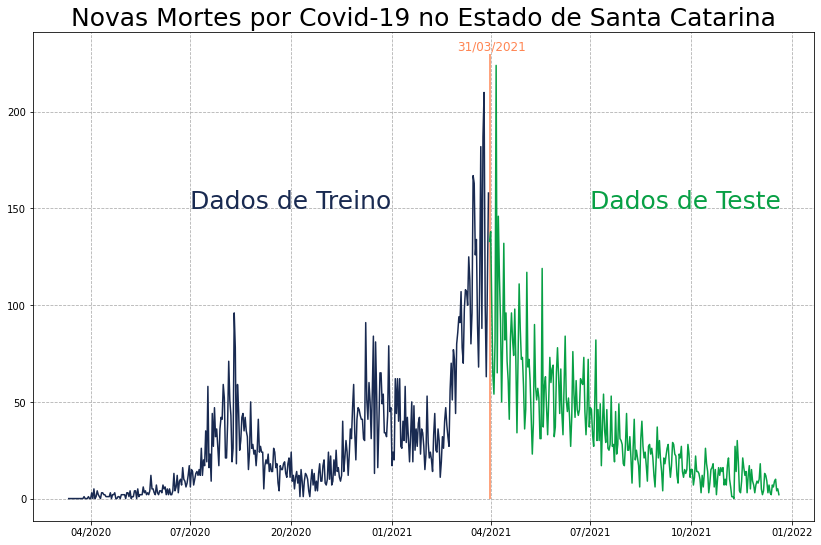

In [ ]:
# Criação do gráfico para visualização dos dados de treino e teste
train_color = '#192A51'
test_color = '#08A045'
vline_color = '#FF8552'
plt.figure(figsize=(14,9))
ax = sns.lineplot(data=data_new_deaths[:400], x='date', y=estado, color = train_color)
ax = sns.lineplot(data=data_new_deaths[400:], x='date', y=estado, color = test_color)
plt.title('Novas Mortes por Covid-19 no Estado de Santa Catarina', fontsize=25)
plt.ylabel('')
plt.xlabel('')
plt.grid(linestyle='--')
plt.style.use('ggplot')
labels_eixo_x = ['04/2020', '07/2020','20/2020','01/2021','04/2021','07/2021','10/2021', '01/2022']
valores_eixo_x = pd.to_datetime(['2020-04-01', '2020-07-01', '2020-10-01', '2021-01-01', '2021-04-01', '2021-07-01', '2021-10-01', '2022-01-01'])
plt.xticks(valores_eixo_x, labels_eixo_x)
plt.text(x=valores_eixo_x[1], y=150, s='Dados de Treino', color=train_color, fontsize=25)
plt.text(x=valores_eixo_x[5], y=150, s='Dados de Teste', color=test_color, fontsize=25)
vline = pd.to_datetime(['2021-03-31'])
plt.vlines(x=vline, ymin=0, ymax=230, color=vline_color)
vline_text_position = pd.to_datetime(['2021-03-01'])
plt.text(x=vline_text_position, y=232, s='31/03/2021', color=vline_color, fontsize=12)
plt.show()

Como podemos visualizar no gráfico acima, dividimos os dados em:


*   Treino: 25 de Fevereiro de 2020 até 31 de Março de 2021;
*   Teste: 31 de Março de 2021 até 20 de Dezembro de 2021.

Podemos ver claramente 3 grandes ondas nos dados, porém iremos fazer a previsão já na fase de descida da terceira onda.

# Modelo básico Prophet

Utilizaremos o modelo do Facebook chamada Facebook Prophet para forecasting (previsão). A ferramenta permite gerar previsões e cenários futuros para séries temporais. Iniciaremos nossas previsões com o modelo mais básico do Prophet, ou seja, sem nenhuma otimização. 

Esse modelo será útil para comparar e verificar se as otimizações de tendência, sazonalidade, feriados e outliers estão surtindo efeito.

Vamos utilizar duas métricas para avaliação do modelo, que são o Erro Médio Absoluto (MAE) e o Raiz do Erro Quadrático Médio (RMSE).

O MAE será a principal métrica uma vez que tem uma menor inflência pelos outliers. Entretanto também iremos ver o RMSE como uma segunda confirmação da otimização do modelo e também para verificar se os outliers não irão impactar muito nas previsões.

In [ ]:
# Criação do Dataframe com os dados de novas mortes em Santa Catarina
df = pd.DataFrame()
df['ds'] = data_new_deaths['date']
df['y'] = data_new_deaths[estado].values
df['cap'] = 300

In [ ]:
# Criação e treinamento do modelo
df_p, _ = prophet_model(df)
# A função prophet_model foi criada nesse notebook e pode ser vista na seção de funções

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


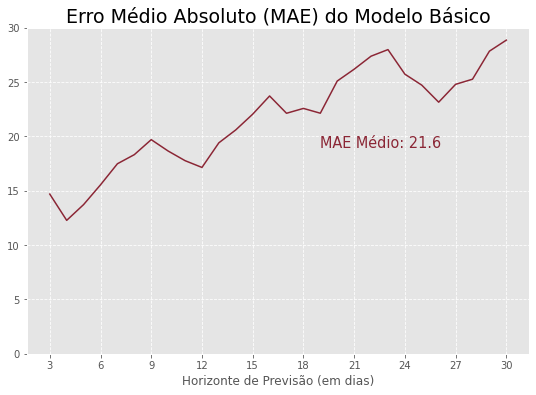

In [ ]:
# Preparando os dados para serem plotados
df_p_plot = df_p.copy()
df_p_plot['horizon_plot'] = [i+3 for i in range(len(df_p_plot['horizon']))]

basic_model_color = '#8B2635'

plt.figure(figsize=(9,6))

sns.lineplot(data=df_p_plot, x='horizon_plot', y='mae', color = basic_model_color)
plt.grid(linestyle='--')
plt.style.use('ggplot')

plt.title('Erro Médio Absoluto (MAE) do Modelo Básico', fontsize=19)
plt.ylabel('')
plt.xlabel('Horizonte de Previsão (em dias)')

labels_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
valores_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
plt.xticks(valores_eixo_x, labels_eixo_x)

plt.ylim(0,30)

plt.text(x=19, y=19, s='MAE Médio: ' + str(round(df_p['mae'].mean(), 2)), color=basic_model_color, fontsize=14.5)

plt.show()

Podemos ver que o modelo básico tem um erro considerável de na média aproximadamente 22 mortes. Este erro começa menor em torno de 15 mortes para previsões mais recentes nos primeiros dias, porém nos últimos dias o erro tende a aumentar para quase 30 mortes.

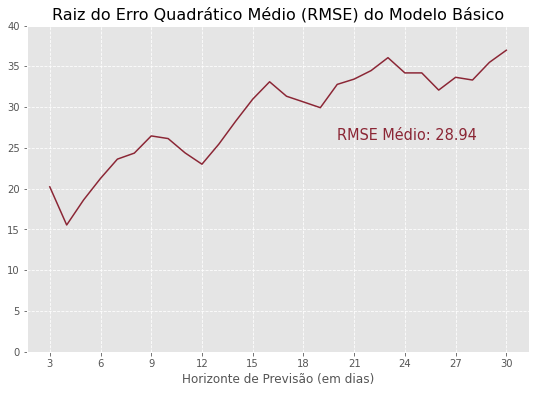

In [ ]:
plt.figure(figsize=(9,6))
sns.lineplot(data=df_p_plot, x='horizon_plot', y='rmse', color = basic_model_color)
plt.grid(linestyle='--')
plt.style.use('ggplot')

plt.title('Raiz do Erro Quadrático Médio (RMSE) do Modelo Básico', fontsize=16)
plt.ylabel('')
plt.xlabel('Horizonte de Previsão (em dias)')

labels_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
valores_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
plt.xticks(valores_eixo_x, labels_eixo_x)

plt.ylim(0,40)

plt.text(x=20, y=26, s='RMSE Médio: ' + str(round(df_p['rmse'].mean(), 2)), color=basic_model_color, fontsize=14.5)

plt.show()

Assim como para o gráfico do MAE, o RMSE também tem um erro considerável para o modelo básico. O RMSE também começa com um erro menor nos primeiros dias de previsão em torno de 20 mortes, porém quando tentamos prever 30 dias no futuro o erro chega acima de 35 mortes.


Com base nos gráficos do MAE e RMSE podemos concluir que o modelo básico não seria confiável o suficiente para tomar alguma decisão baseado nele. Pensando nisso iremos agora para a otimização de tendência, sazonalidade, feriados e outliers.

# Otimizando a Tendência

A tendência será a primeira otimização que faremos do nosso modelo do Prophet. A tendência indica o comportamento de "longo prazo" da serie temporal, isto é, se ela cresce, decresce ou permanece estável. Ela também é responsável por dizer a velocidade dessas mudanças de longo prazo.

Durante a otimização da tendência será feito 3 experimentos e após isso iremos discutir os resultados para definir quais as melhores combinações dos parâmetros de tendência.

In [ ]:
# Criando os dataframes para salvar os resultados dos experimentos da tendência

# Dataframe do MAE
MAE_results_exp_trend = pd.DataFrame()
MAE_results_exp_trend['horizon'] = [i+3 for i in range(len(df_p_plot['horizon']))]
MAE_results_exp_trend['Modelo Básico'] = df_p['mae']

# Dataframe do RMSE
RMSE_results_exp_trend = pd.DataFrame()
RMSE_results_exp_trend['horizon'] = [i+3 for i in range(len(df_p_plot['horizon']))]
RMSE_results_exp_trend['Modelo Básico'] = df_p['rmse']

# Definindo as cores para os plots
basic_model_color = '#8B2635'
trend_exp1_color = '#192A51'
trend_exp2_color = '#08A045'
trend_exp3_color = '#FF8552'

## 1° Experimento de Tendência

No Prophet, dentro os parâmetros de tendência temos 3 parâmetros muito importantes, que são:

*   n_changepoints: número de possíveis changepoints. Cada changepoint é uma possível troca de tendência;
*   changepoint_prior_scale: determina a flexibilidade da tendência, ou seja, a possibilidade da tendência mudar a cada changepoint. Se esse valor é muito pequeno a tendência será underfit. Se for muito grande a tendência será overfit;
*   growth: determina se o crescimento da tendência é linear ou exponencial.


Se nós passarmos um valor inteiro no parâmetro n_changepoints, o Prophet irá determinar os possíveis changepoints por conta própria (respeitando o número de changepoints que nós passamos).

Pensando nisso, nesse primeiro experimento vamos buscar por uma boa combinação entre esses três parâmetros a fim de determinar quantos changepoints seria o ideal, sua flexibilidade de mudança de tendência e qual formato de crescimento seria o melhor.



In [ ]:
params_grid = {'n_changepoints':[i for i in range(5, 55, 5)],
              'changepoint_prior_scale':[i/1000 for i in range(1, 500, 20)],
               'growth':['linear', 'logistic']}
grid = ParameterGrid(params_grid)

enable = False
if enable:
  # Criando o modelo e salvando o resultado em dois dataframes
  MAE, RMSE = prophet_model_grid(df, grid)
  # Arrendondando os resultados de MAE e RMSE
  MAE = round(MAE,2)
  RMSE = round(RMSE,2)
  # Salvando os resultados de MAE e RMSE
  MAE.to_csv('/content/MAE.csv', sep=',',  index=False)
  RMSE.to_csv('/content/RMSE.csv', sep=',',  index=False)
else:
  MAE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Trend/Exp1/MAE.csv', sep=',')
  RMSE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Trend/Exp1/RMSE.csv', sep=',')

In [ ]:
# Melhor combinação de parâmetros para o MAE
param = best_result(MAE, grid)
param

{'changepoint_prior_scale': 0.001, 'growth': 'logistic', 'n_changepoints': 50}

In [ ]:
# Melhor combinação de parâmetros para o RMSE
best_result(RMSE, grid)

{'changepoint_prior_scale': 0.001, 'growth': 'logistic', 'n_changepoints': 50}

Tanto para o MAE quanto para o RMSE foram otimizados o mesmo conjunto de parametros:

*   changepoint_prior_scale: 0.001
*   growth: logistic
*   n_changepoints: 50

Apenas vendo esse conjunto de parâmetros não conseguimos ver se o modelo realmente melhorou, então vamos plotar novamente o gráfico do MAE e do RMSE.



In [ ]:
# Rodando o modelo com o conjunto de parâmetros otimizado
results, modelo = prophet_model(df, parameters=param)

# Salvando os resultados do primeiro experimento
MAE_results_exp_trend['1° Exp. Tendência'] = results['mae']
RMSE_results_exp_trend['1° Exp. Tendência'] = results['rmse']

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


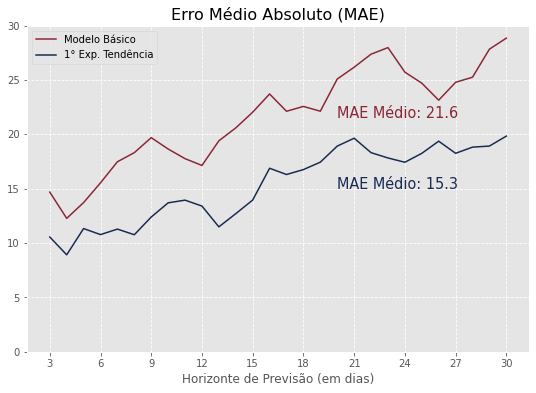

In [ ]:
# Plotando gráfico do MAE
MAE_results_exp_trend.plot(x='horizon', color=[basic_model_color, trend_exp1_color], figsize=(9,6))
plt.grid(linestyle='--')
plt.style.use('ggplot')

plt.title('Erro Médio Absoluto (MAE)', fontsize=16)
plt.ylabel('')
plt.xlabel('Horizonte de Previsão (em dias)')

labels_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
valores_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
plt.xticks(valores_eixo_x, labels_eixo_x)

plt.ylim(0,30)

plt.legend()

plt.text(x=20, y=21.5, s='MAE Médio: ' + str(round(MAE_results_exp_trend['Modelo Básico'].mean(), 2)), color=basic_model_color, fontsize=14.5)
plt.text(x=20, y=15, s='MAE Médio: ' + str(round(MAE_results_exp_trend['1° Exp. Tendência'].mean(), 2)), color=trend_exp1_color, fontsize=14.5)

plt.show()

Analisando o gráfico do MAE podemos ver uma melhora significativa da performace do modelo. Continuamos com a característica do erro menos nas primeiras previsões e com erros maiores nas previsões mais distantes, porém houve uma boa melhora do modelo nesse primeiro experimento.

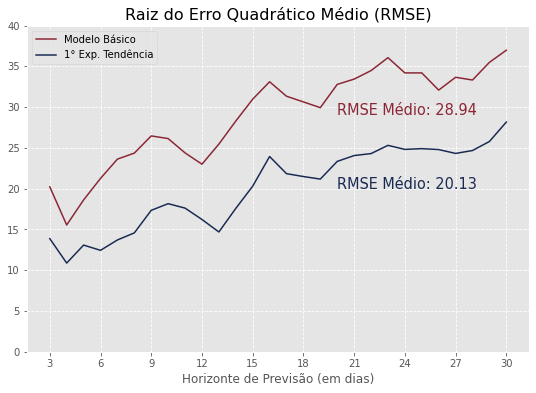

In [ ]:
# Plotando gráfico do RMSE
RMSE_results_exp_trend.plot(x='horizon', color=[basic_model_color, trend_exp1_color], figsize=(9,6))
plt.grid(linestyle='--')
plt.style.use('ggplot')

plt.title('Raiz do Erro Quadrático Médio (RMSE)', fontsize=16)
plt.ylabel('')
plt.xlabel('Horizonte de Previsão (em dias)')

labels_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
valores_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
plt.xticks(valores_eixo_x, labels_eixo_x)

plt.ylim(0,40)

plt.legend()

plt.text(x=20, y=29, s='RMSE Médio: ' + str(round(RMSE_results_exp_trend['Modelo Básico'].mean(), 2)), color=basic_model_color, fontsize=14.5)
plt.text(x=20, y=20, s='RMSE Médio: ' + str(round(RMSE_results_exp_trend['1° Exp. Tendência'].mean(), 2)), color=trend_exp1_color, fontsize=14.5)

plt.show()

A análise do RMSE é muito parecida com a do MAE, onde tivemos uma melhora significativa do erro, porém mantemos um erro maior nas previsões mais distantes.

Agora, vamos visualizar gráficamente os changepoints para esse conjunto de parâmetros.

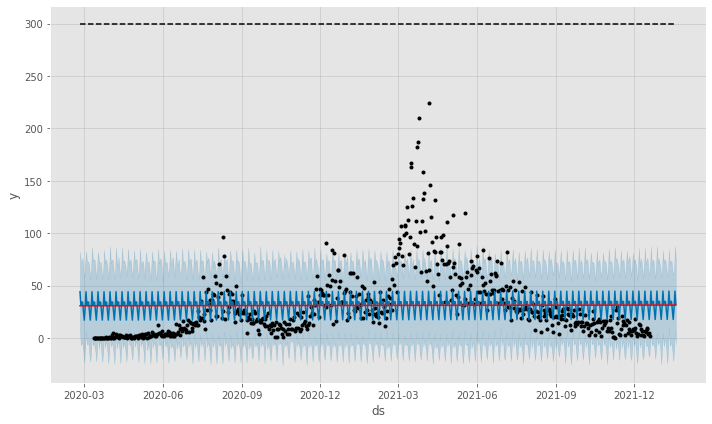

In [ ]:
print_changepoints(modelo)

Vou confessar que esse gráfico me decepcionou um pouco, mas não foi surpresa uma vez que o changepoint_prior_scale=0.001 daria uma flexibilidade muito baixa para o modelo, fazendo com que praticamente não mudasse de tendência nenhuma vez.

Esse resultado apenas prova que o modelo básico realmente não é confiável, assim como o modelo desse primeiro experimento. Com isso, partimos para o segundo experimento.

## 2° Experimento de Tendência

Para o segundo experimento, também vamos tentar otimizar os parâmetros changepoint_prior_scale e growth, porém dessa vez ao invés de apenas dizer para o Prophet quantos possíveis changespoints nós queremos, vamos passar esses possíveis changepoints para ver qual será o comportamento do modelo.

Para definir os possíveis changepoints vamos pegar as mudanças abruptas nos dados, ou seja, vamos pegar quais dias tiveram mais de 50 mortes de diferente entre o dia atual e o anterior, uma vez que essas mudanças abruptas possam indicar uma mudança de tendência.

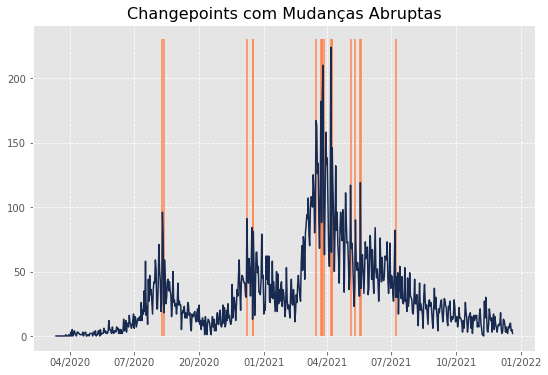

In [ ]:
# Datas com mudanças abruptas de mortes do dia atual com o anterior
df_diff = df.copy()
df_diff['diff'] = df_diff['y'].diff()
dates = [i for i in df_diff.query('(diff < -50) or (diff > 50)')['ds']]

# Visualizando os changepoints selecionados
plt.figure(figsize=(9,6))
ax = sns.lineplot(data=data_new_deaths, x='date', y=estado, color = train_color)
plt.title('Changepoints com Mudanças Abruptas', fontsize=16)
plt.ylabel('')
plt.xlabel('')
plt.grid(linestyle='--')
plt.style.use('ggplot')
labels_eixo_x = ['04/2020', '07/2020','20/2020','01/2021','04/2021','07/2021','10/2021', '01/2022']
valores_eixo_x = pd.to_datetime(['2020-04-01', '2020-07-01', '2020-10-01', '2021-01-01', '2021-04-01', '2021-07-01', '2021-10-01', '2022-01-01'])
plt.xticks(valores_eixo_x, labels_eixo_x)
for i in range(len(dates)):
  vline = pd.to_datetime(dates[i])
  plt.vlines(x=vline, ymin=0, ymax=230, color=vline_color)
plt.show()

Agora que encontramos os possíveis changepoints com mudanças abruptas, vamos procurar a melhor combinação de changepoint_prior_scale e growth para esses changepoints.

In [ ]:
param = {'changepoint_prior_scale' : [i/1000 for i in range(1, 500, 20)],
         'changepoints':[dates],
         'growth':['linear', 'logistic']}
grid = ParameterGrid(param)

enable = False
if enable:
  # Criando o modelo e salvando o resultado em dois dataframes
  MAE, RMSE = prophet_model_grid(df, grid)
  # Arrendondando os resultados de MAE e RMSE
  MAE = round(MAE,2)
  RMSE = round(RMSE,2)
  # Salvando os resultados de MAE e RMSE
  MAE.to_csv('/content/MAE.csv', sep=',',  index=False)
  RMSE.to_csv('/content/RMSE.csv', sep=',',  index=False)
else:
  MAE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Trend/Exp2/MAE.csv', sep=',')
  RMSE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Trend/Exp2/RMSE.csv', sep=',')

In [ ]:
# Achando os melhores resultados do segundo experimento para o MAE
param = best_result(df=MAE, grid=grid)
# Rodando o modelo com os melhores resultados para o MAE
results_best_MAE, modelo_best_MAE = prophet_model(df, parameters=param)

# Achando os melhores resultados do segundo experimento para o RMSE
param_rmse = best_result(df=RMSE, grid=grid)
# Rodando o modelo com os melhores resultados para o RMSE
results_best_RMSE, modelo_best_RMSE = prophet_model(df, parameters=param_rmse)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


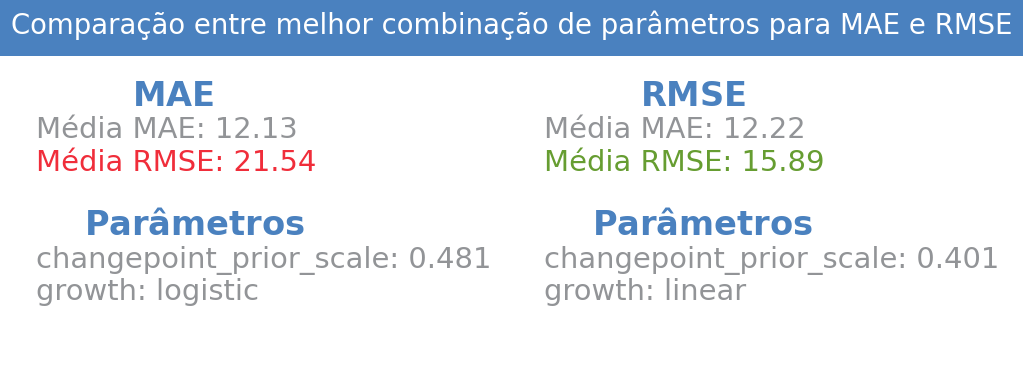

In [ ]:
# define colores
GREEN = '#669D31'
RED = '#F02D3A'
GRAY7 = '#929497'
BLUE2 = '#4A81BF'

# criar nova figura
plt.figure(figsize=(7.45, 3.9), dpi=110)
# remover bordas
for spine in plt.gca().spines.values(): 
  spine.set_visible(False)
# Removendo eixos
plt.axis('off')
# Criando offset em x
offset_x = 0.04

# Adicionando titulo
plt.text(-0.15, 1.03,
'Comparação entre melhor combinação de parâmetros para MAE e RMSE', fontsize=18,
color='white',
# Colocando retangulo no titulo
bbox={'facecolor': BLUE2, 'pad': 10, 'edgecolor': 'none'})

# Adicionando nota
plt.text(0+offset_x, 0.81,
'$\\bf{MAE}$', fontsize=22,
color=BLUE2)

# Adicionando nota
plt.text(-0.15+offset_x, 0.71,
'Média MAE: '+str(round(results_best_MAE['mae'].mean(),2)), fontsize=19,
color=GRAY7)

# Adicionando nota
plt.text(-0.15+offset_x, 0.61,
'Média RMSE: '+str(round(results_best_MAE['rmse'].mean(),2)), fontsize=19,
color=RED)

# Adicionando nota
plt.text(-0.075+offset_x, 0.41,
'$\\bf{Parâmetros}$', fontsize=22,
color=BLUE2)

# Adicionando nota
plt.text(-0.15+offset_x, 0.31,
'changepoint_prior_scale: ' + str(param['changepoint_prior_scale']), fontsize=19,
color=GRAY7)

# Adicionando nota
plt.text(-0.15+offset_x, 0.21,
'growth: ' + str(param['growth']), fontsize=19,
color=GRAY7)

# Adicionando nota
plt.text(0.80+offset_x, 0.81,
'$\\bf{RMSE}$', fontsize=22,
color=BLUE2)

# Adicionando nota
plt.text(0.65+offset_x, 0.71,
'Média MAE: '+str(round(results_best_RMSE['mae'].mean(),2)), fontsize=19,
color=GRAY7)

# Adicionando nota
plt.text(0.65+offset_x, 0.61,
'Média RMSE: '+str(round(results_best_RMSE['rmse'].mean(),2)), fontsize=19,
color=GREEN)

# Adicionando nota
plt.text(0.725+offset_x, 0.41,
'$\\bf{Parâmetros}$', fontsize=22,
color=BLUE2)

# Adicionando nota
plt.text(0.65+offset_x, 0.31,
'changepoint_prior_scale: ' + str(param_rmse['changepoint_prior_scale']), fontsize=19,
color=GRAY7)

# Adicionando nota
plt.text(0.65+offset_x, 0.21,
'growth: ' + str(param_rmse['growth']), fontsize=19,
color=GRAY7)

plt.show()

Do lado esquerdo vemos a combinação de parâmetros que obtiveram o melhor resultado para o MAE. Já do lado direito vemos a combinação de parâmetros que obtiveram o melhor resultado para o RMSE.

A média do MAE foi muito similar, tanto a combinação de parâmetros que obtiveram o melhor resultado para o MAE quanto a combinação de parâmetros que obtiveram o melhor resultado para o RMSE. Porém a média RMSE teve resultados muito melhores para a combinação de parâmetros que obtiveram o melhor resultado para o RMSE.

É nesses momentos que se mostra importantes ter duas métricas de avaliação e não apenas uma. Se fosse apenas o MAE o resultado seria praticamente o mesmo. Com isso seguimos com a combinação da direita para o restante da análise do experimento.

In [ ]:
# Salvando os resultados do primeiro experimento
MAE_results_exp_trend['2° Exp. Tendência'] = results_best_RMSE['mae']
RMSE_results_exp_trend['2° Exp. Tendência'] = results_best_RMSE['rmse']

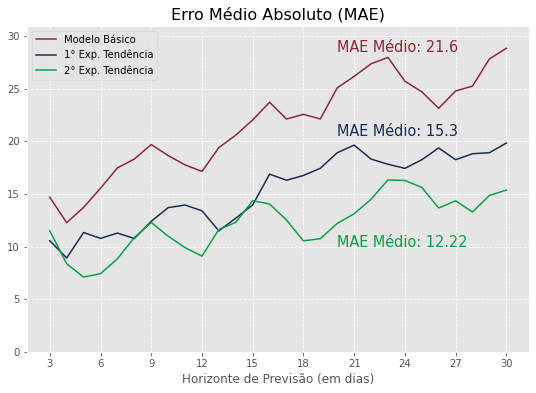

In [ ]:
# Plotando gráfico do MAE
MAE_results_exp_trend.plot(x='horizon', color=[basic_model_color, trend_exp1_color, trend_exp2_color], figsize=(9,6))
plt.grid(linestyle='--')
plt.style.use('ggplot')

plt.title('Erro Médio Absoluto (MAE)', fontsize=16)
plt.ylabel('')
plt.xlabel('Horizonte de Previsão (em dias)')

labels_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
valores_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
plt.xticks(valores_eixo_x, labels_eixo_x)

plt.ylim(0,31)

plt.legend()

plt.text(x=20, y=28.5, s='MAE Médio: ' + str(round(MAE_results_exp_trend['Modelo Básico'].mean(), 2)), color=basic_model_color, fontsize=14.5)
plt.text(x=20, y=20.5, s='MAE Médio: ' + str(round(MAE_results_exp_trend['1° Exp. Tendência'].mean(), 2)), color=trend_exp1_color, fontsize=14.5)
plt.text(x=20, y=10, s='MAE Médio: ' + str(round(MAE_results_exp_trend['2° Exp. Tendência'].mean(), 2)), color=trend_exp2_color, fontsize=14.5)

plt.show()

Neste momento nós começamos a ver o erro não crescer tanto nas previsões mais distantes, apesar de ainda crescer um pouco. Além disso podemos ver que houve uma melhora em comparação ao experimento 1.

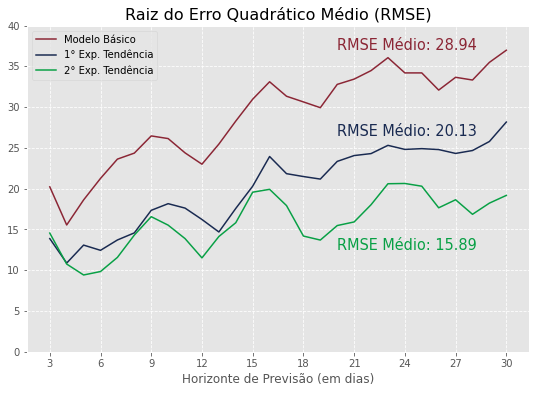

In [ ]:
# Plotando gráfico do RMSE
RMSE_results_exp_trend.plot(x='horizon', color=[basic_model_color, trend_exp1_color, trend_exp2_color], figsize=(9,6))
plt.grid(linestyle='--')
plt.style.use('ggplot')

plt.title('Raiz do Erro Quadrático Médio (RMSE)', fontsize=16)
plt.ylabel('')
plt.xlabel('Horizonte de Previsão (em dias)')

labels_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
valores_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
plt.xticks(valores_eixo_x, labels_eixo_x)

plt.ylim(0,40)

plt.legend()

plt.text(x=20, y=37, s='RMSE Médio: ' + str(round(RMSE_results_exp_trend['Modelo Básico'].mean(), 2)), color=basic_model_color, fontsize=14.5)
plt.text(x=20, y=26.5, s='RMSE Médio: ' + str(round(RMSE_results_exp_trend['1° Exp. Tendência'].mean(), 2)), color=trend_exp1_color, fontsize=14.5)
plt.text(x=20, y=12.5, s='RMSE Médio: ' + str(round(RMSE_results_exp_trend['2° Exp. Tendência'].mean(), 2)), color=trend_exp2_color, fontsize=14.5)

plt.show()

Assim como para o MAE, o RMSE também teve uma pequena diminuição do erro de periodos mais distantes em relação aos periodos mais próximos. Além disso houve uma diminuição do erro em praticamente todos os horizontes de previsão.

Agora, vamos visualizar gráficamente os changepoints para esse conjunto de parâmetros.

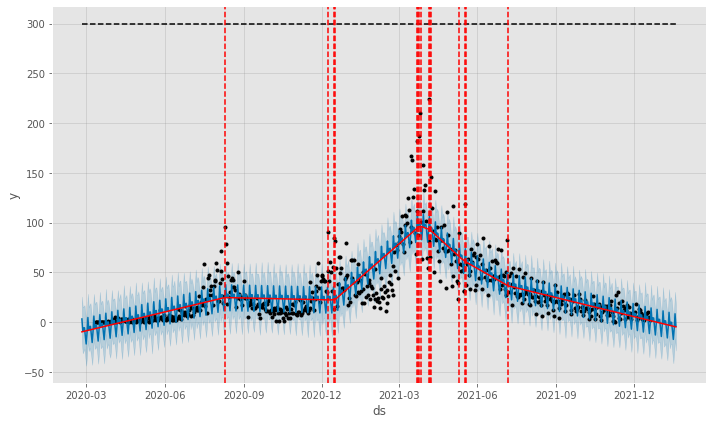

In [ ]:
# Visualizando gráficamente os changepoints
print_changepoints(modelo_best_RMSE)

Agora sim começamos a ver o Prophet modelando um pouco mais os dados para fazer suas previsões. Ele não modelou o perfeitamente as duas primeiras ondas, mas a terceira já está com uma tendência mais ajustada.

## 3° Experimento de Tendência

No terceiro experimento eu resolvi selecionar no olho meus changepoints e buscar a melhor combinação de parâmetros de changepoint_prior_scale e growth para esses changepoints.

A idéia aqui é ver se a intuição humana pode ser mais eficaz que os pontos gerados automáticamente pelo Prophet ou pelos pontos de mudança abrupta.

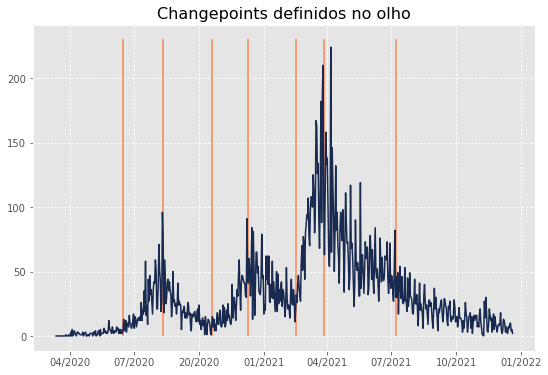

In [ ]:
# Definindo os changepoints no olho
dates2 = [111, 168, 237, 288, 356, 396, 499]
dates2 = [df_diff['ds'][i] for i in dates2]
dates2

# Visualizando os changepoints selecionados
plt.figure(figsize=(9,6))
ax = sns.lineplot(data=data_new_deaths, x='date', y=estado, color = train_color)
plt.title('Changepoints definidos no olho', fontsize=16)
plt.ylabel('')
plt.xlabel('')
plt.grid(linestyle='--')
plt.style.use('ggplot')
labels_eixo_x = ['04/2020', '07/2020','20/2020','01/2021','04/2021','07/2021','10/2021', '01/2022']
valores_eixo_x = pd.to_datetime(['2020-04-01', '2020-07-01', '2020-10-01', '2021-01-01', '2021-04-01', '2021-07-01', '2021-10-01', '2022-01-01'])
plt.xticks(valores_eixo_x, labels_eixo_x)
for i in range(len(dates2)):
  vline = pd.to_datetime(dates2[i])
  plt.vlines(x=vline, ymin=0, ymax=230, color=vline_color)
plt.show()

Agora que temos os changepoints escolhidos no olhomêtro, vamos buscar o melhor conjunto de parâmetro para o MAE e para o RMSE.

In [ ]:
param = {'changepoint_prior_scale' : [i/1000 for i in range(1, 500, 20)],
         'changepoints':[dates2],
         'growth':['linear', 'logistic']}
grid = ParameterGrid(param)

enable = False
if enable:
  # Criando o modelo e salvando o resultado em dois dataframes
  MAE, RMSE = prophet_model_grid(df, grid)
  # Arrendondando os resultados de MAE e RMSE
  MAE = round(MAE,2)
  RMSE = round(RMSE,2)
  # Salvando os resultados
  MAE.to_csv('/content/MAE.csv', sep=',',  index=False)
  RMSE.to_csv('/content/RMSE.csv', sep=',',  index=False)
else:
  MAE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Trend/Exp3/MAE.csv', sep=',')
  RMSE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Trend/Exp3/RMSE.csv', sep=',')

Para esse experimento, nós achamos o mesmo conjunto de parâmetros que foram otimizados para o MAE e para o RMSE.

In [ ]:
param = best_result(df=MAE, grid=grid)
param

{'changepoint_prior_scale': 0.481,
 'changepoints': [Timestamp('2020-06-15 00:00:00'),
  Timestamp('2020-08-11 00:00:00'),
  Timestamp('2020-10-19 00:00:00'),
  Timestamp('2020-12-09 00:00:00'),
  Timestamp('2021-02-15 00:00:00'),
  Timestamp('2021-03-27 00:00:00'),
  Timestamp('2021-07-08 00:00:00')],
 'growth': 'logistic'}

In [ ]:
param_rmse = best_result(df=RMSE, grid=grid)
param_rmse

{'changepoint_prior_scale': 0.481,
 'changepoints': [Timestamp('2020-06-15 00:00:00'),
  Timestamp('2020-08-11 00:00:00'),
  Timestamp('2020-10-19 00:00:00'),
  Timestamp('2020-12-09 00:00:00'),
  Timestamp('2021-02-15 00:00:00'),
  Timestamp('2021-03-27 00:00:00'),
  Timestamp('2021-07-08 00:00:00')],
 'growth': 'logistic'}

Uma vez que temos apenas um conjunto de parâmetro, vamos treinar o modelo e dar uma olhada como ficou os erros.

In [ ]:
# Rodando o modelo com os melhores resultados para o MAE
results_best_MAE, modelo_best_MAE = prophet_model(df, parameters=param)

# Salvando os resultados do primeiro experimento
MAE_results_exp_trend['3° Exp. Tendência'] = results_best_MAE['mae']
RMSE_results_exp_trend['3° Exp. Tendência'] = results_best_MAE['rmse']

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


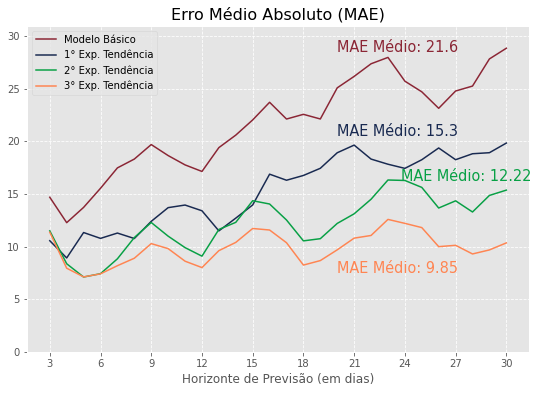

In [ ]:
# Plotando gráfico do MAE
MAE_results_exp_trend.plot(x='horizon', color=[basic_model_color, trend_exp1_color, trend_exp2_color, trend_exp3_color], figsize=(9,6))
plt.grid(linestyle='--')
plt.style.use('ggplot')

plt.title('Erro Médio Absoluto (MAE)', fontsize=16)
plt.ylabel('')
plt.xlabel('Horizonte de Previsão (em dias)')

labels_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
valores_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
plt.xticks(valores_eixo_x, labels_eixo_x)

plt.ylim(0,31)

plt.legend()

plt.text(x=20, y=28.5, s='MAE Médio: ' + str(round(MAE_results_exp_trend['Modelo Básico'].mean(), 2)), color=basic_model_color, fontsize=14.5)
plt.text(x=20, y=20.5, s='MAE Médio: ' + str(round(MAE_results_exp_trend['1° Exp. Tendência'].mean(), 2)), color=trend_exp1_color, fontsize=14.5)
plt.text(x=23.8, y=16.2, s='MAE Médio: ' + str(round(MAE_results_exp_trend['2° Exp. Tendência'].mean(), 2)), color=trend_exp2_color, fontsize=14.5)
plt.text(x=20, y=7.5, s='MAE Médio: ' + str(round(MAE_results_exp_trend['3° Exp. Tendência'].mean(), 2)), color=trend_exp3_color, fontsize=14.5)

plt.show()

O MAE teve uma diminuição muito relevante, ainda mais quando cada vez mais percebemos que o erro não aumenta muito de previsões próximas para previsões mais distantes.

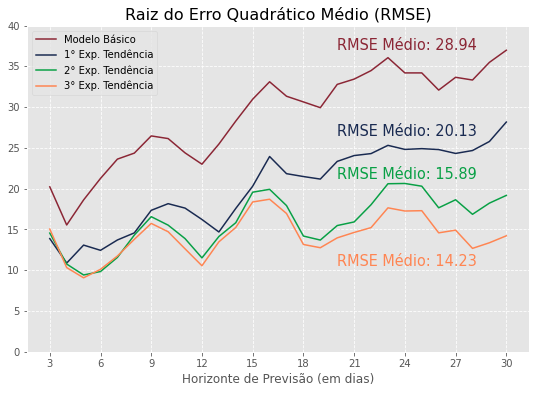

In [ ]:
# Plotando gráfico do RMSE
RMSE_results_exp_trend.plot(x='horizon', color=[basic_model_color, trend_exp1_color, trend_exp2_color, trend_exp3_color], figsize=(9,6))
plt.grid(linestyle='--')
plt.style.use('ggplot')

plt.title('Raiz do Erro Quadrático Médio (RMSE)', fontsize=16)
plt.ylabel('')
plt.xlabel('Horizonte de Previsão (em dias)')

labels_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
valores_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
plt.xticks(valores_eixo_x, labels_eixo_x)

plt.ylim(0,40)

plt.legend()

plt.text(x=20, y=37, s='RMSE Médio: ' + str(round(RMSE_results_exp_trend['Modelo Básico'].mean(), 2)), color=basic_model_color, fontsize=14.5)
plt.text(x=20, y=26.5, s='RMSE Médio: ' + str(round(RMSE_results_exp_trend['1° Exp. Tendência'].mean(), 2)), color=trend_exp1_color, fontsize=14.5)
plt.text(x=20, y=21.2, s='RMSE Médio: ' + str(round(RMSE_results_exp_trend['2° Exp. Tendência'].mean(), 2)), color=trend_exp2_color, fontsize=14.5)
plt.text(x=20, y=10.5, s='RMSE Médio: ' + str(round(RMSE_results_exp_trend['3° Exp. Tendência'].mean(), 2)), color=trend_exp3_color, fontsize=14.5)

plt.show()

O efeito que aconteceu no MAE se reflete em menor escala no RMSE, onde o erro em previsões mais distantes diminuem. Houve um pequeno ganho em relação ao experimento passado, algo que se fosse só para o RMSE poderia não parecer muito, porém olhando as duas métricas podemos afirmar que a melhor otimização de tendência veio do terceiro experimento.

Para finalizar as otimizações de tendência, vamos visualizar os changepoints retirado no olhomêtro e como está ficando a previsão do Prophet.

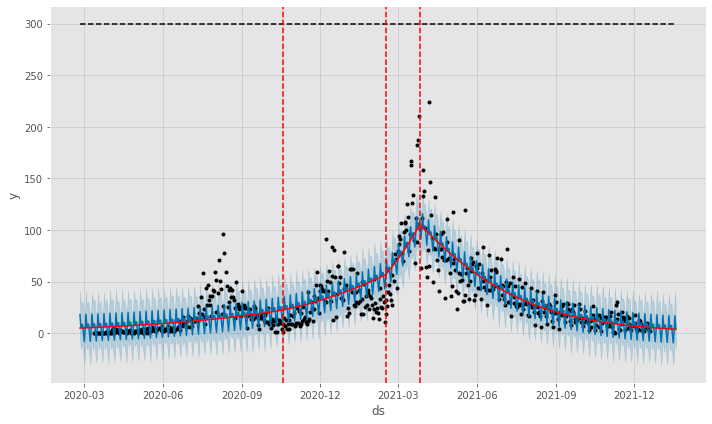

In [ ]:
# Visualizando gráficamente os changepoints
print_changepoints(modelo_best_MAE)

Podemos ver que cada vez mais o modelo está se ajustando aos dados. Apesar de não ter modelado tão bem as duas primeiras ondas, a terceira está cada vez melhor e é justamente ela que influenciará na parte do teste, uma vez que os dados de testes estão justamente na descida da terceira onda.

Também podemos dizer que é super válido o olhar humano no momento da escolha dos changepoints, apesar do Prophet ter a possibilidade de escolher os changepoints sozinho, nesse dataset mostramos que o olhar humano pode ajudar o modelo a se adequar melhor aos dados e fazer melhores previsões.

Neste momento encerramos os experimentos para a otimização da tendência, apesar de existirem diversas ideias para novos experimentos como por exemplo o cruzamento de média móveis como possiveis changepoints. Entretando essas ideias irão ficar para futuros trabalhos e agora iremos focar na otimização da sazoalidade.

# Otimizando Sazonalidade

A Sazonalidade será a segunda otimização que faremos do nosso modelo do Prophet. A sazonalidade diz respeito a fenômenos que ocorrem durante um tempo e se repetem a cada período idêntico de tempo.

Durante a otimização da sazonalidade será feito 2 experimentos e após isso iremos discutir os resultados para definir quais as melhores combinações dos parâmetros de sazonalidade.

In [ ]:
# Criando os dataframes para salvar os resultados dos experimentos da tendência

# Dataframe do MAE
MAE_results_exp_sazon = pd.DataFrame()
MAE_results_exp_sazon['horizon'] = [i+3 for i in range(len(df_p_plot['horizon']))]
MAE_results_exp_sazon['Tendência Otimizada'] = MAE_results_exp_trend['3° Exp. Tendência']


# Dataframe do RMSE
RMSE_results_exp_sazon = pd.DataFrame()
RMSE_results_exp_sazon['horizon'] = [i+3 for i in range(len(df_p_plot['horizon']))]
RMSE_results_exp_sazon['Tendência Otimizada'] = RMSE_results_exp_trend['3° Exp. Tendência']

# Definindo as cores para os plots
trend_model_color = '#8B2635'
sazon_exp1_color = '#192A51'
sazon_exp2_color = '#08A045'

## 1° Experimento de Sazonalidade

Neste momento iremos otimizar os principais parâmetros da sazonalidade, como a sazonalidade semanal, anual, o quão forte essas sazonalidades são com o seasonality_prior_scale, entre outras coisas.


Eu não sei exatamente o porque, mas o seasonality_mode = multiplicative não está funcionando muito bem quando tinhamos valores de seasonality_prior_scale ou algumas combinações com valores baixos de weekly e yearly_seasonality. Então resolvi remover o seasonality_mode dessa parte do experimento, deixando como additive que é o default para poder testar os outros parâmetros.

In [ ]:
params_grid = {'changepoint_prior_scale': [0.481],
 'changepoints': [['2020-06-15',
  '2020-08-11',
  '2020-10-19',
  '2020-12-09',
  '2021-02-15',
  '2021-03-27',
  '2021-07-08']],
 'growth': ['logistic'],
 'seasonality_prior_scale':[0.01, 0.1, 1.0, 10.0],
 'yearly_seasonality':[True, False, 5, 10, 15, 20, 25],
 'weekly_seasonality':[True, False, 5, 10, 15, 20, 25]}


grid = ParameterGrid(params_grid)

enable = False
if enable:
  # Criando o modelo e salvando o resultado em dois dataframes
  MAE, RMSE = prophet_model_grid(df, grid)
  # Arrendondando os resultados de MAE e RMSE
  MAE = round(MAE,2)
  RMSE = round(RMSE,2)
  # Salvando os resultados
  MAE.to_csv('/content/MAE.csv', sep=',',  index=False)
  RMSE.to_csv('/content/RMSE.csv', sep=',',  index=False)
else:
  MAE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Seasonality/Exp1/MAE.csv', sep=',')
  RMSE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Seasonality/Exp1/RMSE.csv', sep=',')

Neste experimento de sazonalidade, o mesmo conjunto de parâmetro foi o melhor otimizado tanto para o MAE, quanto para o RMSE.

In [ ]:
param = best_result(df=MAE, grid=grid)
param

{'changepoint_prior_scale': 0.481,
 'changepoints': ['2020-06-15',
  '2020-08-11',
  '2020-10-19',
  '2020-12-09',
  '2021-02-15',
  '2021-03-27',
  '2021-07-08'],
 'growth': 'logistic',
 'seasonality_prior_scale': 0.01,
 'weekly_seasonality': 10,
 'yearly_seasonality': False}

In [ ]:
param_rmse = best_result(df=RMSE, grid=grid)
param_rmse

{'changepoint_prior_scale': 0.481,
 'changepoints': ['2020-06-15',
  '2020-08-11',
  '2020-10-19',
  '2020-12-09',
  '2021-02-15',
  '2021-03-27',
  '2021-07-08'],
 'growth': 'logistic',
 'seasonality_prior_scale': 0.01,
 'weekly_seasonality': 10,
 'yearly_seasonality': False}

Como não foi possível utilizar o modo multiplicativo na otimização desse experimento, eu realizei alguns testes e cheguei em um melhor resultado com o modo de sazonalidade multiplicativo e desativando a sazonalidade anual, como já havia sido otimizado anteriormente.

In [ ]:
# Melhor conjunto de parâmetros selecionados
param = {'changepoint_prior_scale': 0.481,
 'changepoints': ['2020-06-15',
  '2020-08-11',
  '2020-10-19',
  '2020-12-09',
  '2021-02-15',
  '2021-03-27',
  '2021-07-08'],
 'growth': 'logistic',
 'seasonality_prior_scale': 1.0,
 'weekly_seasonality': 10,
 'yearly_seasonality': False,
 'seasonality_mode': 'multiplicative'}

# Rodando o modelo com os parâmetros acima selecionados
results, modelo = prophet_model(df, parameters=param)

# Salvando o resultado da otimização de sazonalidade
MAE_results_exp_sazon['1° Exp. Sazonalidade'] = results['mae']
RMSE_results_exp_sazon['1° Exp. Sazonalidade'] = results['rmse']

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


Portando, vamos visualizar como ficaram os erros após essas otimizações de sazoanlidade:

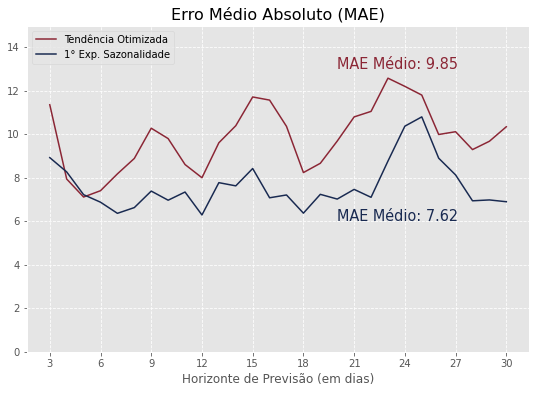

In [ ]:
# Plotando gráfico do MAE
MAE_results_exp_sazon.plot(x='horizon', color=[trend_model_color, sazon_exp1_color], figsize=(9,6))
plt.grid(linestyle='--')
plt.style.use('ggplot')

plt.title('Erro Médio Absoluto (MAE)', fontsize=16)
plt.ylabel('')
plt.xlabel('Horizonte de Previsão (em dias)')

labels_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
valores_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
plt.xticks(valores_eixo_x, labels_eixo_x)

plt.ylim(0,15)

plt.legend(loc='upper left')

plt.text(x=20, y=13, s='MAE Médio: ' + str(round(MAE_results_exp_sazon['Tendência Otimizada'].mean(), 2)), color=trend_model_color, fontsize=14.5)
plt.text(x=20, y=6, s='MAE Médio: ' + str(round(MAE_results_exp_sazon['1° Exp. Sazonalidade'].mean(), 2)), color=sazon_exp1_color, fontsize=14.5)

plt.show()

Como era de se esperar, com uma otimização da sazonalidade, podemos ver o erro mais uniforme durante os horizontes. Se olha bem, a curva da tendência otimizada tem um formato de seno mostrando claramente uma sazonalidade não otimizada ali. 

O principal objetivo desses experimentos de sazonalidades é conseguir uma curva que não tenha esse aspecto de seno e como podemos ver no gráfico acima, conseguimos diminuir esse efeito.

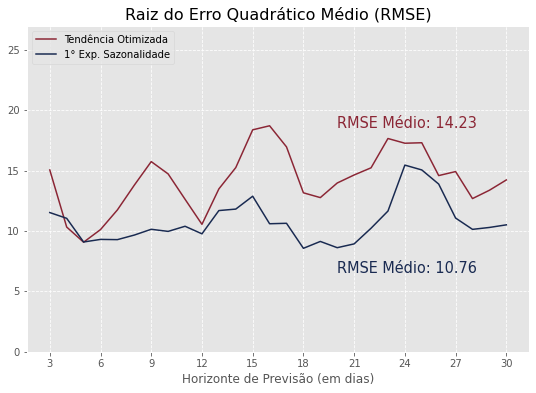

In [ ]:
# Plotando gráfico do RMSE
RMSE_results_exp_sazon.plot(x='horizon', color=[trend_model_color, sazon_exp1_color], figsize=(9,6))
plt.grid(linestyle='--')
plt.style.use('ggplot')

plt.title('Raiz do Erro Quadrático Médio (RMSE)', fontsize=16)
plt.ylabel('')
plt.xlabel('Horizonte de Previsão (em dias)')

labels_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
valores_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
plt.xticks(valores_eixo_x, labels_eixo_x)

plt.ylim(0,27)

plt.legend(loc='upper left')

plt.text(x=20, y=18.5, s='RMSE Médio: ' + str(round(RMSE_results_exp_sazon['Tendência Otimizada'].mean(), 2)), color=trend_model_color, fontsize=14.5)
plt.text(x=20, y=6.5, s='RMSE Médio: ' + str(round(RMSE_results_exp_sazon['1° Exp. Sazonalidade'].mean(), 2)), color=sazon_exp1_color, fontsize=14.5)

plt.show()

Assim como no gráfico do MAE, também diminuimos o efeito de seno que vinha sendo apresentado na curca da tendência otimizada. Entretando temos um pico de erro no horizonte 24 que acredito eu ser devido a um outlier. Acredito que durante a otimização dos outliers esse pico desapareça do gráfico. 

Para finalizar esse experimento, vamos visualizar os changepoints do melhor modelo até agora e já aproveitar para ver as previsões do modelo.

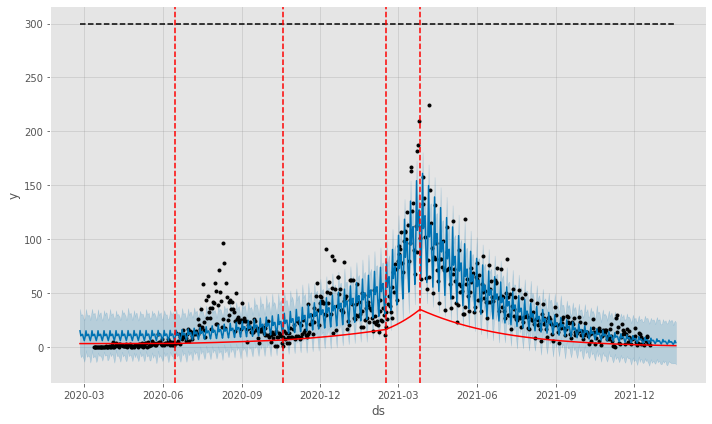

In [ ]:
# Visualizando as previsões do melhor modelo e seus changepoints
print_changepoints(modelo)

Como era de se esperar, com uma otimização da sazonalidade, o modelo está conseguindo prever cada ver melhor os dados, principalmente da descida da terceira onda. Conseguindo deixar em sua grande maioria dentro do intervalo de confiança.

## 2° Experimento de Sazonalidade

Para o segundo experimento de sazonalidade, vamos dar uma olhada na autocorrelação.

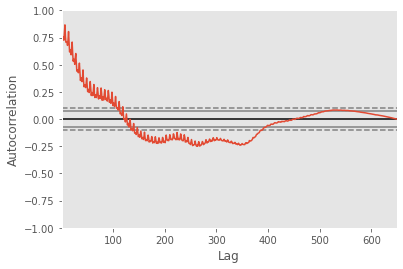

In [ ]:
autocorrelation_plot(df['y'][16:])

Percebemos que existem algumas regiões com correlação significativa, como por exemplo antes do Lag 100 e até mesmo após o Lag 120 até por volta do 380, mas dessa vez uma correlação negativa.

Neste experimento vamos retirar algumas possiveis sazonalidades e testá-las para ver se melhoramos a performace do nosso modelo.

In [ ]:
# Sazonalidades retiradas para o teste do experimento
possiveis_sazonalidades = [7, 14, 21, 30.5, 45, 60, 75, 90, 170, 260, 350]

In [ ]:
param = {'changepoint_prior_scale': 0.481,
 'changepoints': ['2020-06-15',
  '2020-08-11',
  '2020-10-19',
  '2020-12-09',
  '2021-02-15',
  '2021-03-27',
  '2021-07-08'],
 'growth': 'logistic',
 'seasonality_prior_scale': 1.0,
 'weekly_seasonality': 10,
 'yearly_seasonality': False,
 'seasonality_mode': 'additive'}

params_grid = {'period':possiveis_sazonalidades,
              'fourier_order':[5, 10, 15, 20, 25]}

grid = ParameterGrid(params_grid)

enable = False
if enable:
  # Criando o modelo e salvando o resultado em dois dataframes
  MAE, RMSE = prophet_model_grid_sazon(df[16:], param, grid)
  # Arrendondando os resultados de MAE e RMSE
  MAE = round(MAE,2)
  RMSE = round(RMSE,2)
  # Salvando os resultados
  MAE.to_csv('/content/MAE.csv', sep=',',  index=False)
  RMSE.to_csv('/content/RMSE.csv', sep=',',  index=False)
else:
  MAE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Seasonality/Exp2/MAE.csv', sep=',')
  RMSE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Seasonality/Exp2/RMSE.csv', sep=',')

In [ ]:
param = best_result(df=MAE, grid=grid)
param

{'fourier_order': 25, 'period': 90}

In [ ]:
param_rmse = best_result(df=RMSE, grid=grid)
param_rmse

{'fourier_order': 15, 'period': 90}

Visualizando os gráficos dos erros.

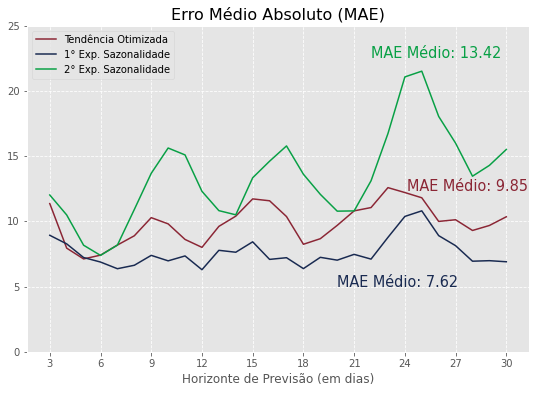

In [ ]:
# Salvando melhor resultado do segundo experimento
MAE_results_exp_sazon['2° Exp. Sazonalidade'] = MAE[MAE.mean().sort_values().head(1).index[0]]
# Plotando gráfico do MAE
MAE_results_exp_sazon.plot(x='horizon', color=[trend_model_color, sazon_exp1_color, sazon_exp2_color], figsize=(9,6))
plt.grid(linestyle='--')
plt.style.use('ggplot')

plt.title('Erro Médio Absoluto (MAE)', fontsize=16)
plt.ylabel('')
plt.xlabel('Horizonte de Previsão (em dias)')

labels_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
valores_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
plt.xticks(valores_eixo_x, labels_eixo_x)

plt.ylim(0,25)

plt.legend(loc='upper left')

plt.text(x=24.1, y=12.3, s='MAE Médio: ' + str(round(MAE_results_exp_sazon['Tendência Otimizada'].mean(), 2)), color=trend_model_color, fontsize=14.5)
plt.text(x=20, y=5, s='MAE Médio: ' + str(round(MAE_results_exp_sazon['1° Exp. Sazonalidade'].mean(), 2)), color=sazon_exp1_color, fontsize=14.5)
plt.text(x=22, y=22.5, s='MAE Médio: ' + str(round(MAE_results_exp_sazon['2° Exp. Sazonalidade'].mean(), 2)), color=sazon_exp2_color, fontsize=14.5)

plt.show()

Claramente esse experimento não foi bem sucedido pois além de aumentar o erro, parece que o erro por sazonalidade aumentou também como podemos ver no formato de seno no gráfico.

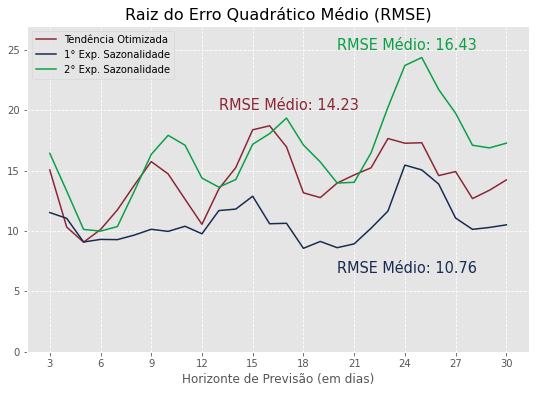

In [ ]:
# Salvando melhor resultado do segundo experimento
RMSE_results_exp_sazon['2° Exp. Sazonalidade'] = RMSE[RMSE.mean().sort_values().head(1).index[0]]
# Plotando gráfico do RMSE
RMSE_results_exp_sazon.plot(x='horizon', color=[trend_model_color, sazon_exp1_color, sazon_exp2_color], figsize=(9,6))
plt.grid(linestyle='--')
plt.style.use('ggplot')

plt.title('Raiz do Erro Quadrático Médio (RMSE)', fontsize=16)
plt.ylabel('')
plt.xlabel('Horizonte de Previsão (em dias)')

labels_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
valores_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
plt.xticks(valores_eixo_x, labels_eixo_x)

plt.ylim(0,27)

plt.legend(loc='upper left')

plt.text(x=13, y=20, s='RMSE Médio: ' + str(round(RMSE_results_exp_sazon['Tendência Otimizada'].mean(), 2)), color=trend_model_color, fontsize=14.5)
plt.text(x=20, y=6.5, s='RMSE Médio: ' + str(round(RMSE_results_exp_sazon['1° Exp. Sazonalidade'].mean(), 2)), color=sazon_exp1_color, fontsize=14.5)
plt.text(x=20, y=25, s='RMSE Médio: ' + str(round(RMSE_results_exp_sazon['2° Exp. Sazonalidade'].mean(), 2)), color=sazon_exp2_color, fontsize=14.5)

plt.show()

Os resultados foram bem piores do que do primeiro experimento. Mesmo fazendo alguns testes com o modo multiplicativo não foram achados nenhuma combinação que atinja o resultado do primeiro experimento de sazonalidade.

Dessa forma encerramos a otimização de sazonalidade, ficando com o modelo do primeiro experimento. Na próxima seção iremos otimizar os feriados.

# Otimizando os Feriados

Os feriados são peça importante na previsão de series temporais. além de feriados, também é possível prever eventos especificos com os mesmos recursos dos feriados.

In [ ]:
# Criando os dataframes para salvar os resultados dos experimentos da tendência

# Dataframe do MAE
MAE_results_exp_holidays = pd.DataFrame()
MAE_results_exp_holidays['horizon'] = [i+3 for i in range(len(df_p_plot['horizon']))]
MAE_results_exp_holidays['Sazonalidade Otimizada'] = MAE_results_exp_sazon['1° Exp. Sazonalidade']

# Dataframe do RMSE
RMSE_results_exp_holidays = pd.DataFrame()
RMSE_results_exp_holidays['horizon'] = [i+3 for i in range(len(df_p_plot['horizon']))]
RMSE_results_exp_holidays['Sazonalidade Otimizada'] = RMSE_results_exp_sazon['1° Exp. Sazonalidade']

# Definindo as cores para os plots
sazon_model_color = '#8B2635'
holidays_exp1_color = '#192A51'
holidays_exp2_color = '#08A045'

## 1° Experimento de Feriados

No primeiro experimento dos feriados, vamos otimizar o parâmetro holidays_prior_scale para os feriados nacionais que já vem no Prophet. 

A ideia é verificar se esses feriados tem alguma relevancia para a previsão de mortes por Covid-19 em Santa Catarina.

In [ ]:
holidays_prior_scale_list = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]

param = {'changepoint_prior_scale': 0.481,
 'changepoints': ['2020-06-15',
  '2020-08-11',
  '2020-10-19',
  '2020-12-09',
  '2021-02-15',
  '2021-03-27',
  '2021-07-08'],
 'growth': 'logistic',
 'seasonality_prior_scale': 1.0,
 'weekly_seasonality': 10,
 'yearly_seasonality': False,
 'seasonality_mode': 'multiplicative'}

enable = False
if enable:
  # Criando o modelo e salvando o resultado em dois dataframes
  MAE, RMSE = prophet_model_country_holidays(df, parameters=param, country_holidays=True, holidays_prior_scale_list=holidays_prior_scale_list)
  # Arrendondando os resultados de MAE e RMSE
  MAE = round(MAE,2)
  RMSE = round(RMSE,2)
  # Salvando os resultados
  MAE.to_csv('/content/MAE.csv', sep=',',  index=False)
  RMSE.to_csv('/content/RMSE.csv', sep=',',  index=False)
else:
  MAE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Holidays/Exp1/MAE.csv', sep=',')
  RMSE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Holidays/Exp1/RMSE.csv', sep=',')

Verificando o resultado dos feriados nacionais

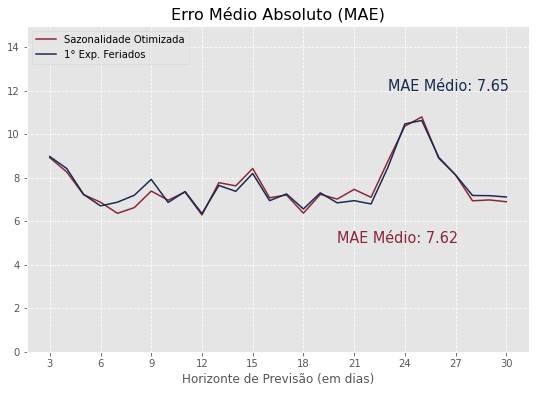

In [ ]:
# Salvando melhor resultado do segundo experimento
MAE_results_exp_holidays['1° Exp. Feriados'] = MAE[MAE.mean().sort_values().head(1).index[0]]
# Plotando gráfico do MAE
MAE_results_exp_holidays.plot(x='horizon', color=[sazon_model_color, holidays_exp1_color], figsize=(9,6))
plt.grid(linestyle='--')
plt.style.use('ggplot')

plt.title('Erro Médio Absoluto (MAE)', fontsize=16)
plt.ylabel('')
plt.xlabel('Horizonte de Previsão (em dias)')

labels_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
valores_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
plt.xticks(valores_eixo_x, labels_eixo_x)

plt.ylim(0,15)

plt.legend(loc='upper left')

plt.text(x=20, y=5, s='MAE Médio: ' + str(round(MAE_results_exp_holidays['Sazonalidade Otimizada'].mean(), 2)), color=trend_model_color, fontsize=14.5)
plt.text(x=23, y=12, s='MAE Médio: ' + str(round(MAE_results_exp_holidays['1° Exp. Feriados'].mean(), 2)), color=sazon_exp1_color, fontsize=14.5)

plt.show()

Podemos ver que os feriados nacionais não influenciaram muito no modelo, em alguns pontos especificos sim, porém na média o modelo ficou levemente pior do que quando não tinha os feriados nacionais.

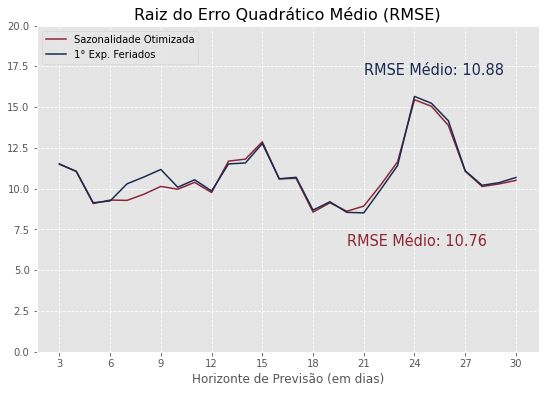

In [ ]:
# Salvando melhor resultado do segundo experimento
RMSE_results_exp_holidays['1° Exp. Feriados'] = RMSE[RMSE.mean().sort_values().head(1).index[0]]
# Plotando gráfico do RMSE
RMSE_results_exp_holidays.plot(x='horizon', color=[sazon_model_color, holidays_exp1_color], figsize=(9,6))
plt.grid(linestyle='--')
plt.style.use('ggplot')

plt.title('Raiz do Erro Quadrático Médio (RMSE)', fontsize=16)
plt.ylabel('')
plt.xlabel('Horizonte de Previsão (em dias)')

labels_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
valores_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
plt.xticks(valores_eixo_x, labels_eixo_x)

plt.ylim(0,20)

plt.legend(loc='upper left')

plt.text(x=20, y=6.5, s='RMSE Médio: ' + str(round(RMSE_results_exp_holidays['Sazonalidade Otimizada'].mean(), 2)), color=trend_model_color, fontsize=14.5)
plt.text(x=21, y=17, s='RMSE Médio: ' + str(round(RMSE_results_exp_holidays['1° Exp. Feriados'].mean(), 2)), color=sazon_exp1_color, fontsize=14.5)

plt.show()

Assim como para o MAE, O RMSE também não foi muito influenciado pelos feriados nacionais e serão descartados nos próximos experimentos devido a não contrinuição para melhora da perfomace do modelo.

## 2° Experimento de Feriados

Nesse experimento, nós vamos buscar os feriados do estado de Santa Catarina e verificar se algum desses feriados consegue ajudar a melhorar a performace do modelo. 

In [ ]:
feriados = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Holidays/Exp2/Holidays_from_2020_2021_2022.txt', encoding="utf-8", sep=';')
feriados.head()

,ds,holiday
0,01/01/2020,Ano Novo
1,24/02/2020,Carnaval
2,25/02/2020,Carnaval
3,26/02/2020,Carnaval
4,10/04/2020,Sexta-Feira Santa


In [ ]:
# Visualizando todos os feriados de Santa Catarina
nome_feriados = list(feriados['holiday'].unique())
nome_feriados

['Ano Novo',
 'Carnaval',
 'Sexta-Feira Santa',
 'Dia de Tiradentes',
 'Dia do Trabalho',
 'Corpus Christi',
 'Independência do Brasil',
 'Nossa Senhora Aparecida',
 'Dia do Professor',
 'Dia do Servidor Público',
 'Dia de Finados',
 'Proclamação da República',
 'Natal']

### Parte 1: Selecionandos os feriados que melhoram a performace do modelo

Agora, iremos fazer uma analise de cada feriado separadamente.

In [ ]:
prior_scale = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]

param = {'changepoint_prior_scale': 0.481,
 'changepoints': ['2020-06-15',
  '2020-08-11',
  '2020-10-19',
  '2020-12-09',
  '2021-02-15',
  '2021-03-27',
  '2021-07-08'],
 'growth': 'logistic',
 'seasonality_prior_scale': 1.0,
 'weekly_seasonality': 10,
 'yearly_seasonality': False,
 'seasonality_mode': 'multiplicative'}

initial_i = 0
initial_j = 0
jump_because_error = {'Dia do Trabalho': [5.0],
                      'Independência do Brasil': [0.05, 1.0],
                      'Dia do Professor': [0.1],
                      'Dia de Finados': [1.0],
                      'Proclamação da República': [10.0],
                      'Natal': [0.1, 5.0]}

enable = False
if enable:
  # Criando o modelo e salvando o resultado em dois dataframes
  MAE, RMSE = prophet_model_holidays(df, parameters=param, holidays=feriados, prior_scale=prior_scale, initial_i=initial_i, initial_j=initial_j, jump=jump_because_error)
  # Arrendondando os resultados de MAE e RMSE
  MAE = round(MAE,2)
  RMSE = round(RMSE,2)
  # Salvando os resultados
  MAE.to_csv('/content/MAE.csv', sep=',',  index=False)
  RMSE.to_csv('/content/RMSE.csv', sep=',',  index=False)
else:
  MAE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Holidays/Exp2/Part_1_MAE.csv', sep=',')
  RMSE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Holidays/Exp2/Part_1_RMSE.csv', sep=',')

Visualizando as combinações de feriados e prior scale que fizeram o modelo performar melhor:

MAE

In [ ]:
MAE.sort_values(by='MAE_Mean', inplace=True)
MAE[MAE['MAE_Mean'] < round(MAE_results_exp_sazon['1° Exp. Sazonalidade'].mean(),2)].drop_duplicates(subset='holiday')

,holiday,prior_scale,MAE_Mean
17,Sexta-Feira Santa,0.50,7.50
1,Ano Novo,0.05,7.56
51,Nossa Senhora Aparecida,5.00,7.58
80,Natal,0.50,7.59
59,Dia do Servidor Público,0.01,7.60
70,Dia de Finados,5.00,7.61


RMSE

In [ ]:
RMSE.sort_values(by='RMSE_Mean', inplace=True)
RMSE[RMSE['RMSE_Mean'] < round(RMSE_results_exp_sazon['1° Exp. Sazonalidade'].mean(),2)].drop_duplicates(subset='holiday')

,holiday,prior_scale,RMSE_Mean
17,Sexta-Feira Santa,0.50,10.55
1,Ano Novo,0.05,10.68
80,Natal,0.50,10.71
51,Nossa Senhora Aparecida,5.00,10.72


Vamos apenas pegar os feriados que fizeram o modelo performar melhor nas duas métricas (MAE e RMSE).

No caso, será os mesmos feriados que foram filtrados do RMSE, uma vez que todos esses feriados também ajudam a melhorar a performace do MAE.

### Parte 2: Achando a melhor combinação dos feriados que melhoram a performace do modelo

Dataframe auxiliar para criar a coluna prior_scale

In [ ]:
Aux_Feriados = RMSE[RMSE['RMSE_Mean'] < round(RMSE_results_exp_sazon['1° Exp. Sazonalidade'].mean(),2)].drop_duplicates(subset='holiday')
Aux_Feriados = Aux_Feriados[['holiday', 'prior_scale']]
Aux_Feriados

,holiday,prior_scale
17,Sexta-Feira Santa,0.50
1,Ano Novo,0.05
80,Natal,0.50
51,Nossa Senhora Aparecida,5.00


Selecionando os feriados que serão usados na criação do modelo:

In [ ]:
feriados_selecionados = list(RMSE[RMSE['RMSE_Mean'] < round(RMSE_results_exp_sazon['1° Exp. Sazonalidade'].mean(),2)].drop_duplicates(subset='holiday')['holiday'])
feriados_selecionados

['Sexta-Feira Santa', 'Ano Novo', 'Natal', 'Nossa Senhora Aparecida']

Criando todas as combinação de todos os feriados selecionados

In [ ]:
combinacao_de_feriados = grid_list(feriados_selecionados)
combinacao_de_feriados

[['Sexta-Feira Santa'],
 ['Ano Novo'],
 ['Sexta-Feira Santa', 'Ano Novo'],
 ['Natal'],
 ['Sexta-Feira Santa', 'Natal'],
 ['Ano Novo', 'Natal'],
 ['Sexta-Feira Santa', 'Ano Novo', 'Natal'],
 ['Nossa Senhora Aparecida'],
 ['Sexta-Feira Santa', 'Nossa Senhora Aparecida'],
 ['Ano Novo', 'Nossa Senhora Aparecida'],
 ['Sexta-Feira Santa', 'Ano Novo', 'Nossa Senhora Aparecida'],
 ['Natal', 'Nossa Senhora Aparecida'],
 ['Sexta-Feira Santa', 'Natal', 'Nossa Senhora Aparecida'],
 ['Ano Novo', 'Natal', 'Nossa Senhora Aparecida'],
 ['Sexta-Feira Santa', 'Ano Novo', 'Natal', 'Nossa Senhora Aparecida']]

Dataframe com os feriados selecionados e seus prior scale:

In [ ]:
param = {'changepoint_prior_scale': 0.481,
 'changepoints': ['2020-06-15',
  '2020-08-11',
  '2020-10-19',
  '2020-12-09',
  '2021-02-15',
  '2021-03-27',
  '2021-07-08'],
 'growth': 'logistic',
 'seasonality_prior_scale': 1.0,
 'weekly_seasonality': 10,
 'yearly_seasonality': False,
 'seasonality_mode': 'multiplicative'}

jump_combination = [13]

enable = False
if enable:
  MAE, RMSE = prophet_model_combination_holidays(df, 
                                                 parameters=param, 
                                                 df_holidays=feriados, 
                                                 prior_scale_table=Aux_Feriados, 
                                                 combination_holidays=combinacao_de_feriados, 
                                                 jump_combination=jump_combination)
  # Arrendondando os resultados de MAE e RMSE
  MAE = round(MAE,2)
  RMSE = round(RMSE,2)
  # Salvando os resultados
  MAE.to_csv('/content/MAE.csv', sep=',',  index=False)
  RMSE.to_csv('/content/RMSE.csv', sep=',',  index=False)
else:
  MAE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Holidays/Exp2/Part_2_MAE.csv', sep=',')
  RMSE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Holidays/Exp2/Part_2_RMSE.csv', sep=',')

As 4 melhores combinações foram as 4 combinações onde tem apenas 1 feriado selecionado

In [ ]:
for i in MAE.mean().sort_values().head(4).index:
  print(combinacao_de_feriados[int(i)])

['Sexta-Feira Santa']
['Ano Novo']
['Nossa Senhora Aparecida']
['Natal']


In [ ]:
for i in RMSE.mean().sort_values().head(4).index:
  print(combinacao_de_feriados[int(i)])

['Sexta-Feira Santa']
['Ano Novo']
['Natal']
['Nossa Senhora Aparecida']


Isso para mim não faz muito sentido uma vez que separados eles melhoram a performace do modelo e cada feriado vai influenciar em sua data especifica. Portanto se justassemos uma combinação deles, deveriamos ter um resultado melhor do que eles indivualmente. 

O experimento não resultou como imaginado, mas tivemos uma melhora na performace do modelo adicionando o feridado de Sexta-Feira Santa ao modelo. 

Rodando o modelo com o feriado de Sexta-Feira Santa.

In [ ]:
param = {'changepoint_prior_scale': 0.481,
 'changepoints': ['2020-06-15',
  '2020-08-11',
  '2020-10-19',
  '2020-12-09',
  '2021-02-15',
  '2021-03-27',
  '2021-07-08'],
 'growth': 'logistic',
 'seasonality_prior_scale': 1.0,
 'weekly_seasonality': 10,
 'yearly_seasonality': False,
 'seasonality_mode': 'multiplicative'}

# Criando a tabela de feriados
selected_holidays = feriados[feriados['holiday'] == 'Sexta-Feira Santa'].merge(Aux_Feriados, on='holiday', how='left')
param['holidays'] = selected_holidays
# Treinando o modelo
results, modelo = prophet_model(df, parameters=param)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


In [ ]:
# Salvando feriados
df_feriados_selecionados = feriados[feriados['holiday'] == 'Sexta-Feira Santa'].merge(Aux_Feriados, on='holiday', how='left')
df_feriados_selecionados.to_csv('/content/df_feriados_selecionados.csv', sep=',', index=False)

In [ ]:
# Salvando os resultados do segundo experimento
MAE_results_exp_holidays['2° Exp. Feriados'] = results['mae']
RMSE_results_exp_holidays['2° Exp. Feriados'] = results['rmse']

Visualizando os gráficos dos erros:

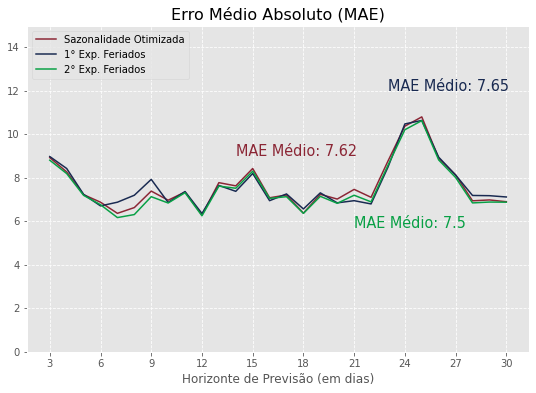

In [ ]:
# Plotando gráfico do MAE
MAE_results_exp_holidays.plot(x='horizon', color=[sazon_model_color, holidays_exp1_color, holidays_exp2_color], figsize=(9,6))
plt.grid(linestyle='--')
plt.style.use('ggplot')

plt.title('Erro Médio Absoluto (MAE)', fontsize=16)
plt.ylabel('')
plt.xlabel('Horizonte de Previsão (em dias)')

labels_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
valores_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
plt.xticks(valores_eixo_x, labels_eixo_x)

plt.ylim(0,15)

plt.legend(loc='upper left')

plt.text(x=14, y=9, s='MAE Médio: ' + str(round(MAE_results_exp_holidays['Sazonalidade Otimizada'].mean(), 2)), color=trend_model_color, fontsize=14.5)
plt.text(x=23, y=12, s='MAE Médio: ' + str(round(MAE_results_exp_holidays['1° Exp. Feriados'].mean(), 2)), color=sazon_exp1_color, fontsize=14.5)
plt.text(x=21, y=5.7, s='MAE Médio: ' + str(round(MAE_results_exp_holidays['2° Exp. Feriados'].mean(), 2)), color=sazon_exp2_color, fontsize=14.5)

plt.show()

Podemos ver que houve uma pequena melhora no desempenho do modelo. Nada muito significativo, porém houve uma pequena melhora devido a inclusão do feriado de Sexta-Feira Santa.

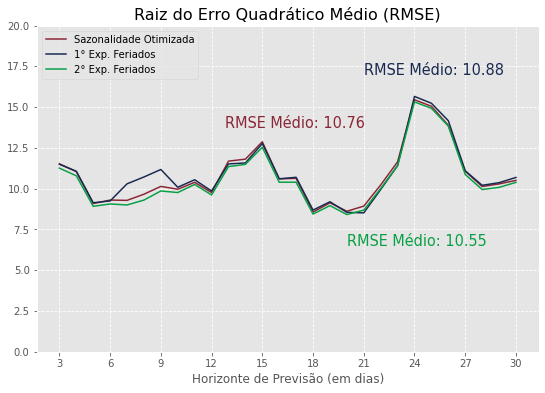

In [ ]:
# Plotando gráfico do RMSE
RMSE_results_exp_holidays.plot(x='horizon', color=[sazon_model_color, holidays_exp1_color, holidays_exp2_color], figsize=(9,6))
plt.grid(linestyle='--')
plt.style.use('ggplot')

plt.title('Raiz do Erro Quadrático Médio (RMSE)', fontsize=16)
plt.ylabel('')
plt.xlabel('Horizonte de Previsão (em dias)')

labels_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
valores_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
plt.xticks(valores_eixo_x, labels_eixo_x)

plt.ylim(0,20)

plt.legend(loc='upper left')

plt.text(x=12.8, y=13.7, s='RMSE Médio: ' + str(round(RMSE_results_exp_holidays['Sazonalidade Otimizada'].mean(), 2)), color=trend_model_color, fontsize=14.5)
plt.text(x=21, y=17, s='RMSE Médio: ' + str(round(RMSE_results_exp_holidays['1° Exp. Feriados'].mean(), 2)), color=sazon_exp1_color, fontsize=14.5)
plt.text(x=20, y=6.5, s='RMSE Médio: ' + str(round(RMSE_results_exp_holidays['2° Exp. Feriados'].mean(), 2)), color=sazon_exp2_color, fontsize=14.5)

plt.show()

Assim como no MAE, o gráfico do RMSE também houve uma pequena melhora no desempenho com a inclusão do feriado de Sexta-Feira Santa, porém nada muito significativo.

Infelizmente nesse projeto não conseguimos otimizar muito os feriados, nada que fosse de extrema importância pelo menos. Agora é hora de tratar os outliers.

# Otimizando os Outliers


O tratamento de outliers é de extrema importância pois eles podem influenciar muito nosso modelo. 

Como já temos um modelo otimizado por tendência, sazonalidade e feriados, vamos considerar os pontos que estão fora do intervalo de confiança como outliers e vamos removê-los.

In [ ]:
# Criando os dataframes para salvar os resultados dos experimentos da tendência

# Dataframe do MAE
MAE_results_exp_outliers = pd.DataFrame()
MAE_results_exp_outliers['horizon'] = [i+3 for i in range(len(df_p_plot['horizon']))]
MAE_results_exp_outliers['Feriados Otimizado'] = MAE_results_exp_holidays['2° Exp. Feriados']

# Dataframe do RMSE
RMSE_results_exp_outliers = pd.DataFrame()
RMSE_results_exp_outliers['horizon'] = [i+3 for i in range(len(df_p_plot['horizon']))]
RMSE_results_exp_outliers['Feriados Otimizado'] = RMSE_results_exp_holidays['2° Exp. Feriados']

# Definindo as cores para os plots
holidays_model_color = '#8B2635'
outliers_exp1_color = '#192A51'

Treinando nosso melhor modelo até o momento:

In [ ]:
param = {'changepoint_prior_scale': 0.481,
 'changepoints': ['2020-06-15',
  '2020-08-11',
  '2020-10-19',
  '2020-12-09',
  '2021-02-15',
  '2021-03-27',
  '2021-07-08'],
 'growth': 'logistic',
 'seasonality_prior_scale': 1.0,
 'weekly_seasonality': 10,
 'yearly_seasonality': False,
 'seasonality_mode': 'multiplicative',
 'holidays': feriados[feriados['holiday'] == 'Sexta-Feira Santa'].merge(Aux_Feriados, on='holiday', how='left')}

results, modelo = prophet_model(df, parameters=param)
print("Melhor resultado MAE: ", round(results['mae'].mean(),2))
print("Melhor resultado RMSE: ", round(results['rmse'].mean(),2))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


Melhor resultado MAE:  7.5
Melhor resultado RMSE:  10.55


Retirando os outliers que estão fora do intervalo de confiança do nosso melhor modelo:

In [ ]:
enable = False
if enable:
  previsao = modelo.predict(df)
  df_sem_outliers = df[(df['y'] > previsao['yhat_lower']) & (df['y'] < previsao['yhat_upper'])]
  len(df_sem_outliers)
else:
  df_sem_outliers = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Outliers/df_sem_outliers.csv', sep=',')

Vendo o resultado do modelo sem outliers

In [ ]:
param = {'changepoint_prior_scale': 0.481,
 'changepoints': ['2020-06-15',
  '2020-08-11',
  '2020-10-19',
  '2020-12-09',
  '2021-02-15',
  '2021-03-27',
  '2021-07-08'],
 'growth': 'logistic',
 'seasonality_prior_scale': 1.0,
 'weekly_seasonality': 10,
 'yearly_seasonality': False,
 'seasonality_mode': 'multiplicative',
 'holidays': feriados[feriados['holiday'] == 'Sexta-Feira Santa'].merge(Aux_Feriados, on='holiday', how='left')}

# Treinando o modelo
results, modelo = prophet_model(df_sem_outliers, parameters=param)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


In [ ]:
# Salvando o dataframe sem outliers
df_sem_outliers.to_csv('/content/df_sem_outliers.csv', sep=',', index=False)

Agora vamos visualizar gráficamente como ficou nosso modelo sem outliers.

In [ ]:
MAE_results_exp_outliers['1° Exp. Outliers'] = round(results['mae'], 2)
RMSE_results_exp_outliers['1° Exp. Outliers'] = round(results['rmse'], 2)

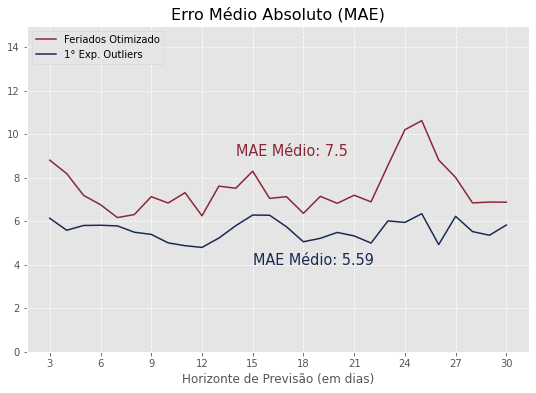

In [ ]:
# Plotando gráfico do MAE
MAE_results_exp_outliers.plot(x='horizon', color=[holidays_model_color, outliers_exp1_color], figsize=(9,6))
plt.grid(linestyle='--')
plt.style.use('ggplot')

plt.title('Erro Médio Absoluto (MAE)', fontsize=16)
plt.ylabel('')
plt.xlabel('Horizonte de Previsão (em dias)')

labels_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
valores_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
plt.xticks(valores_eixo_x, labels_eixo_x)

plt.ylim(0,15)

plt.legend(loc='upper left')

plt.text(x=14, y=9, s='MAE Médio: ' + str(round(MAE_results_exp_outliers['Feriados Otimizado'].mean(), 2)), color=holidays_model_color, fontsize=14.5)
plt.text(x=15, y=4, s='MAE Médio: ' + str(round(MAE_results_exp_outliers['1° Exp. Outliers'].mean(), 2)), color=outliers_exp1_color, fontsize=14.5)

plt.show()

A performace do modelo melhorou muito após a remoção dos outliers. Tanto a curva está mais suave na maioria dos pontos, quanto perto do horizonte de 24 dias que antes tinha um pico de erro muito grande e agora não existe mais esse pico.

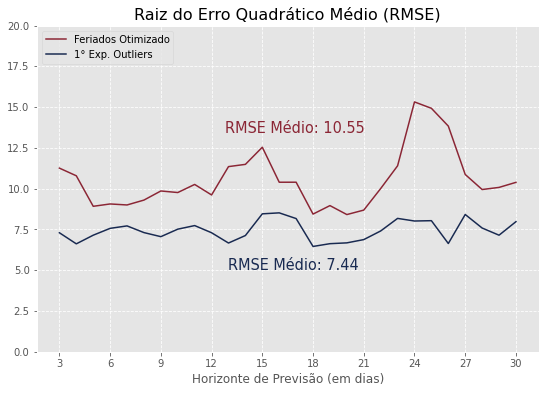

In [ ]:
# Plotando gráfico do RMSE
RMSE_results_exp_outliers.plot(x='horizon', color=[holidays_model_color, outliers_exp1_color], figsize=(9,6))
plt.grid(linestyle='--')
plt.style.use('ggplot')

plt.title('Raiz do Erro Quadrático Médio (RMSE)', fontsize=16)
plt.ylabel('')
plt.xlabel('Horizonte de Previsão (em dias)')

labels_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
valores_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
plt.xticks(valores_eixo_x, labels_eixo_x)

plt.ylim(0,20)

plt.legend(loc='upper left')

plt.text(x=12.8, y=13.4, s='RMSE Médio: ' + str(round(RMSE_results_exp_outliers['Feriados Otimizado'].mean(), 2)), color=trend_model_color, fontsize=14.5)
plt.text(x=13, y=5, s='RMSE Médio: ' + str(round(RMSE_results_exp_outliers['1° Exp. Outliers'].mean(), 2)), color=sazon_exp1_color, fontsize=14.5)

plt.show()

Assim como o MAE, o RMSE também conseguiu melhorar significamente a performace do modelo. Tanto deixando a curva mais suave, quanto removendo aquele pico de erro que tinha perto do horizonte de 24 dias.

# Comparação dos modelos criados e considerações finais

Nesta seção vamos apresentar a comparação entre todas as otimizações feitas nesse notebook. Vamos conseguir ver cada otimização individualmente e podemos ver o quanto nosso modelo melhorou em ambas os erros.

In [ ]:
# Criando dataframe para plotar resultados

# MAE
df_results_MAE = pd.DataFrame()
df_results_MAE['horizon'] = [i+3 for i in range(len(df_p_plot['horizon']))]
df_results_MAE['Básico'] = df_p['mae']
df_results_MAE['Tendência'] = MAE_results_exp_trend['3° Exp. Tendência']
df_results_MAE['Sazonalidade'] = MAE_results_exp_sazon['1° Exp. Sazonalidade']
df_results_MAE['Feriados'] = MAE_results_exp_holidays['2° Exp. Feriados']
df_results_MAE['Outliers'] = MAE_results_exp_outliers['1° Exp. Outliers']

# RMSE
df_results_RMSE = pd.DataFrame()
df_results_RMSE['horizon'] = [i+3 for i in range(len(df_p_plot['horizon']))]
df_results_RMSE['Básico'] = df_p['rmse']
df_results_RMSE['Tendência'] = RMSE_results_exp_trend['3° Exp. Tendência']
df_results_RMSE['Sazonalidade'] = RMSE_results_exp_sazon['1° Exp. Sazonalidade']
df_results_RMSE['Feriados'] = RMSE_results_exp_holidays['2° Exp. Feriados']
df_results_RMSE['Outliers'] = RMSE_results_exp_outliers['1° Exp. Outliers']

# Definindo as cores para os plots
basic_model_color = '#8B2635'
trend_color = '#192A51'
sazon_color = '#08A045'
holidays_color = '#FF8552'
outliers_color = '#FF3C38'

Visualizando o resultado pelo Erro Médio Absoluto (MAE)

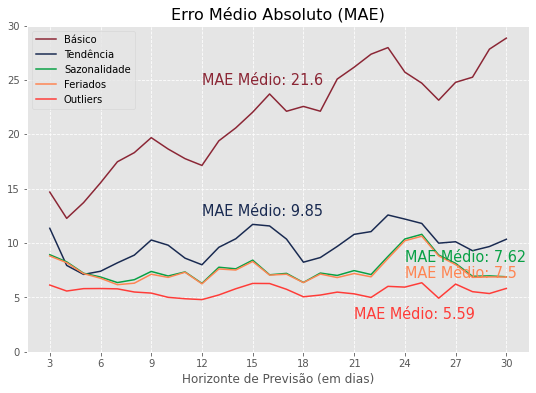

In [ ]:
# Plotando gráfico do MAE
df_results_MAE.plot(x='horizon', color=[basic_model_color, trend_color, sazon_color, holidays_color, outliers_color], figsize=(9,6))
plt.grid(linestyle='--')
plt.style.use('ggplot')

plt.title('Erro Médio Absoluto (MAE)', fontsize=16)
plt.ylabel('')
plt.xlabel('Horizonte de Previsão (em dias)')

labels_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
valores_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
plt.xticks(valores_eixo_x, labels_eixo_x)

plt.ylim(0,30)

plt.legend(loc='upper left')

plt.text(x=12, y=24.5, s='MAE Médio: ' + str(round(df_results_MAE['Básico'].mean(), 2)), color=basic_model_color, fontsize=14.5)
plt.text(x=12, y=12.5, s='MAE Médio: ' + str(round(df_results_MAE['Tendência'].mean(), 2)), color=trend_color, fontsize=14.5)
plt.text(x=24, y=8.3, s='MAE Médio: ' + str(round(df_results_MAE['Sazonalidade'].mean(), 2)), color=sazon_color, fontsize=14.5)
plt.text(x=24, y=6.8, s='MAE Médio: ' + str(round(df_results_MAE['Feriados'].mean(), 2)), color=holidays_color, fontsize=14.5)
plt.text(x=21, y=3, s='MAE Médio: ' + str(round(df_results_MAE['Outliers'].mean(), 2)), color=outliers_color, fontsize=14.5)

plt.show()

É gigantesca a diferença entre o modelo básico e o modelo totalmente otimizado (ainda daria para melhorar mais). Conseguimos ter uma previsão muito mais confiável agora das próximas mortes por Covid-19 em Santa Catarina, pois temos um gráfico mais suave e sem grandes oscilações.

É muito interessante notar os aspectos que cada tipo de otimização altera no gráfico, como por exemplo a perda da oscilação em formato de seno após a otimização por sazonalidade. Outro exemplo seria a curva cada vez mais horizontal após a otimização da tendência. Além disso, como os outliers deixam o gráfico bem menos suave.

Visualizando o resultado pelo Raiz Quadrada do Erro Médio (RMSE)

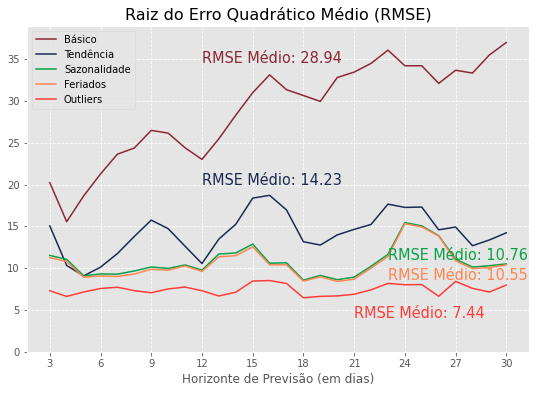

In [ ]:
# Plotando gráfico do RMSE
df_results_RMSE.plot(x='horizon', color=[basic_model_color, trend_color, sazon_color, holidays_color, outliers_color], figsize=(9,6))
plt.grid(linestyle='--')
plt.style.use('ggplot')

plt.title('Raiz do Erro Quadrático Médio (RMSE)', fontsize=16)
plt.ylabel('')
plt.xlabel('Horizonte de Previsão (em dias)')

labels_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
valores_eixo_x = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
plt.xticks(valores_eixo_x, labels_eixo_x)

plt.ylim(0,39)

plt.legend(loc='upper left')

plt.text(x=12, y=34.5, s='RMSE Médio: ' + str(round(df_results_RMSE['Básico'].mean(), 2)), color=basic_model_color, fontsize=14.5)
plt.text(x=12, y=20, s='RMSE Médio: ' + str(round(df_results_RMSE['Tendência'].mean(), 2)), color=trend_color, fontsize=14.5)
plt.text(x=23, y=11, s='RMSE Médio: ' + str(round(df_results_RMSE['Sazonalidade'].mean(), 2)), color=sazon_color, fontsize=14.5)
plt.text(x=23, y=8.6, s='RMSE Médio: ' + str(round(df_results_RMSE['Feriados'].mean(), 2)), color=holidays_color, fontsize=14.5)
plt.text(x=21, y=4, s='RMSE Médio: ' + str(round(df_results_RMSE['Outliers'].mean(), 2)), color=outliers_color, fontsize=14.5)

plt.show()

O modelo conseguiu otimizar tanto para o MAE quanto para o RMSE. Isso dá um duplo check na validação do modelo uma vez que nao estavamos apenas visualizando apenas uma métrica.

O Prophet é um framework muito poderoso para fazer previsões de series temporais e acredito que isso foi demonstrado nesse notebook fazendo a previsão de mortes em Santa Catarina pelo Covid-19. Acredito que todas as otimizações (tendência, sazonalidade, feriados e outliers) tem seus pontos de melhoria e diversas outras ideias para que o modelo performace ainda melhor, porém acredito que consegui concluir o objetivo do notebook que era fazer a otimização de um modelo de serie temporais utilizando o Prophet.